### Geographically Weighted Regression (GWR)

Geographically Weighted Regression (GWR) is used to explore how the relationships between energy consumption and influencing factors—such as subsidies, coaching, building characteristics, and demographics—vary across neighborhoods. This spatial analysis technique helps identify regional differences in the effectiveness of energy transition policies, offering localized insights that can guide more targeted interventions.



### Datasets Used

1. **coachgesprekken_with_neighbourhood.csv**  
   Coaching session data with geolocation and neighborhood-level information.  
   **Key columns**:  
   `datum_afspraak_coachgesprek`, `postcode`, `latitude`, `longitude`, `buurt_naam`

2. **sde_minimized_with_neighbourhood.csv**  
   SDE+ subsidy project data, including project categories and implementation year by location.  
   **Key columns**:  
   `programma`, `categorie`, `realisatiejaar`, `latitude`, `longitude`, `buurt_naam`

3. **Zwolle_Neighbourhood_Aggregated_Buildings.csv**  
   Aggregated building characteristics per neighborhood, grouped by construction period and energy performance.  
   **Key columns**:  
   `buurt_naam`, `building age ranges` , `energy efficiency categories`

4. **demographics_buurt_combined.csv**  
   Neighborhood-level demographic and socioeconomic indicators over time.  
   **Key columns**:  
   `buurt_naam`, `year`, `inkomen`, `huishoudens_onder_105`, `population breakdown by age`

5. **energyconsumption_buurt_combined_filtered.csv**  
   Core outcome variables: electricity and gas usage, CO₂ emissions at the neighborhood level.  
   **Key columns**:  
   `Elektriciteitsverbruik woningen [GWh (miljoen kWh)]`,  
   `Totaal aardgasverbruik woningen`,  
   `CO2-uitstoot Woningen`,  
   `year`, `Buurt_naam`

6. **isde_minimized_with_neighbourhood.csv**  
   ISDE subsidy data for individual sustainability measures (e.g., insulation, heat pumps), including location data.  
   **Key columns**:  
   `postcode`, `wijknaam`, `buurtnaam`, `subsidiejaar`, `techniek`, `subcategorie`, `latitude`, `longitude`

7. **sce_minimized_with_neighbourhood.csv**  
   SCE project data for cooperative solar energy projects, with spatial and neighborhood details.  
   **Key columns**:  
   `projectnummer`, `programma`, `realisatiejaar`, `categorie`, `latitude`, `longitude`, `buurt_naam`

8. **local_subsidies_minimized.csv**  
   Local municipal subsidy data for home energy improvements in Zwolle.  
   **Key columns**:  
   `postal_code`, `place`, `bad_isolated_parts_of_the_house`, `date`, `amount_of_money`,  
   `measures`, `do-it-yourself?`, `ventilation_measure?`, `buurt-naam`, `disctrict_cbs`


In [2]:
## Load Libraries
import pandas as pd
import os
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from mgwr.gwr import GWR
import seaborn as sns
from mgwr.sel_bw import Sel_BW
from collections import defaultdict
from mpl_toolkits.axes_grid1 import make_axes_locatable
from esda.moran import Moran
from libpysal.weights import Queen
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')





## Loading all the data and view them with an aim to inspect if all of them are standardized correctly.This is important in the merging

In [3]:

# Set working directory
Data_Directory = r"D:\Quartile 3\DATA\Model data"
os.chdir(Data_Directory)

# Load Data
coaching_data = pd.read_csv("coachgesprekken_with_neighbourhood.csv")
sde_data = pd.read_csv("sde_minimized_with_neighbourhood.csv")
building_data = pd.read_csv("Zwolle_Neighbourhood_Aggregated_Buildings.csv")
demographics_data = pd.read_csv("demographics_buurt_combined.csv")
energy_data = pd.read_csv("energyconsumption_buurt_combined_filtered.csv")
isde_data = pd.read_csv("isde_minimized_with_neighbourhood.csv")
sce_data = pd.read_csv("sce_minimized_with_neighbourhood.csv")
local_subsidy_data = pd.read_csv("local_subsidies_minimized.csv")  

# Display Samples
print("Coaching Sample:")
display(coaching_data.head())

print("SDE Sample:")
display(sde_data.head())

print("Building Sample:")
display(building_data.head())

print("Demographics Sample:")
display(demographics_data.head())

print("Energy Sample:")
display(energy_data.head())

print("ISDE Sample:")
display(isde_data.head())

print("SCE Sample:")
display(sce_data.head())

print("Local Subsidy Sample:")
display(local_subsidy_data.head())





Coaching Sample:


telling datum_afspraak_coachgesprek postcode   latitude  longitude  \
0        1                  2023-04-01   8024AP  52.523789   6.141788   
1        2                  2023-05-01   8016HM  52.489114   6.103673   
2        3                  2023-05-01   8032EN  52.531460   6.094571   
3        4                  2023-06-01   8024BB  52.526443   6.135351   
4        5                  2023-06-01   8024PC  52.515063   6.137063   

   index_right  OBJECTID  BRTNR           OMSCHR         OFFICIËLE  \
0         34.0     113.0  400.0           Berkum            Berkum   
1         52.0     131.0  503.0   Schellerlanden    Schellerlanden   
2         18.0      97.0  311.0  Aalanden-midden  Aa-landen-Midden   
3         34.0     113.0  400.0           Berkum            Berkum   
4         16.0      95.0  402.0         Veldhoek          Veldhoek   

      SHAPEAREA     SHAPELEN        buurt_naam  
0  1.366110e+06  4899.344643            Berkum  
1  7.420670e+05  4035.293459    Schellerlanden  
2  8.317402e+05  3955.034171  Aa-landen-Midden  
3  1.366110e+06  4899.344643            Berkum  
4  3.208887e+06  8476.613579          Veldhoek

SDE Sample:


projectnummer programma  realisatiejaar      categorie maximale_subsidie  \
0    SDE1308118       SDE            2015  Zonne-energie         1,408,950   
1    SDE1312395       SDE            2016  Zonne-energie           421,290   
2    SDE1355367       SDE            2015  Zonne-energie         3,496,066   
3    SDE1406477       SDE            2017  Zonne-energie           599,460   
4    SDE1413144       SDE            2017  Zonne-energie           202,395   

    latitude  longitude  index_right  OBJECTID  BRTNR  \
0  52.468987   6.106763         33.0     112.0  521.0   
1  52.494547   6.139094         62.0     141.0  411.0   
2  52.546132   6.175369         65.0     144.0  404.0   
3  52.517043   6.078091          1.0      80.0  200.0   
4  52.512395   6.101777         44.0     123.0  133.0   

                         OMSCHR                         OFFICIËLE  \
0         Harculo en Hoogzutmen            Harculo en Hoog-Zuthem   
1   Bedrijventerrein Marslanden  Bedrijventerrein Marslanden-Zuid   
2  Bedrijventerrein Hessenpoort      Bedrijventerrein Hessenpoort   
3     Bedrijventerrein Voorst-A         Bedrijventerrein Voorst-A   
4                   Wezenlanden                       Wezenlanden   

      SHAPEAREA      SHAPELEN                        buurt_naam  
0  1.140856e+07  19981.837249            Harculo en Hoog-Zuthem  
1  2.620659e+06   8350.982217  Bedrijventerrein Marslanden-Zuid  
2  6.014803e+06  11251.359080      Bedrijventerrein Hessenpoort  
3  7.130356e+05   3729.350674         Bedrijventerrein Voorst-A  
4  5.713596e+05   3546.554214                       Wezenlanden

Building Sample:


buurt_naam  total_buil  occupied_p  unoccupied  pre_1945  1945_1960  \
0  aa-landen-midden      1595.0   99.874608    0.125392       0.0        0.0   
1   aa-landen-noord       896.0   98.549107    1.450893       0.0        2.0   
2    aa-landen-oost       803.0   99.003736    0.996264       0.0        0.0   
3    aa-landen-zuid       813.0   99.753998    0.246002       0.0        0.0   
4      bagijneweide       324.0   99.691358    0.308642     160.0       19.0   

   1961_1980  1981_2000  2001_2010  2011_2024  high_effic  moderate_e  \
0     1351.0      144.0       21.0        0.0       380.0      1184.0   
1      783.0       95.0       16.0        0.0       281.0       599.0   
2      752.0       16.0        0.0        0.0       269.0       529.0   
3      781.0        1.0        6.0        0.0        27.0       713.0   
4       14.0       48.0       66.0        0.0       144.0       122.0   

   low_effici  unknown_ef  
0        23.0         8.0  
1        16.0         0.0  
2         4.0         1.0  
3        48.0        25.0  
4        53.0         5.0

Demographics Sample:


buurt_naam  woningen  woonruimten_totaal  inwoners_op_1_januari  \
0   binnenstad-zuid      1253                1254                   2046   
1  binnenstad-noord       548                 551                    801   
2     noordereiland       316                 337                    556   
3       het noorden       902                 906                   1363   
4    schildersbuurt       174                 174                    391   

   inwoners_in_de_leeftijd_van_03_jaar  inwoners_in_de_leeftijd_van_411_jaar  \
0                                 47.0                                  72.0   
1                                 13.0                                   9.0   
2                                 21.0                                  21.0   
3                                 53.0                                  47.0   
4                                 21.0                                  30.0   

   inwoners_in_de_leeftijd_van_1217_jaar  \
0                                   41.0   
1                                    8.0   
2                                   20.0   
3                                   24.0   
4                                   20.0   

   inwoners_in_de_leeftijd_van_1824_jaar  \
0                                  427.0   
1                                  154.0   
2                                   49.0   
3                                  378.0   
4                                   46.0   

   inwoners_in_de_leeftijd_van_2539_jaar  \
0                                  813.0   
1                                  358.0   
2                                  145.0   
3                                  430.0   
4                                  100.0   

   inwoners_in_de_leeftijd_van_4054_jaar  \
0                                  316.0   
1                                  114.0   
2                                   93.0   
3                                  172.0   
4                                   80.0   

   inwoners_in_de_leeftijd_van_5564_jaar  \
0                                  160.0   
1                                   62.0   
2                                   93.0   
3                                   80.0   
4                                   38.0   

   inwoners_in_de_leeftijd_van_6574_jaar  \
0                                  115.0   
1                                   65.0   
2                                   77.0   
3                                   83.0   
4                                   37.0   

   inwoners_in_de_leeftijd_van_7584_jaar  \
0                                   48.0   
1                                   16.0   
2                                   23.0   
3                                   77.0   
4                                   18.0   

   inwoners_in_de_leeftijd_van_85_jaar_en_ouder  \
0                                           7.0   
1                                           2.0   
2                                          14.0   
3                                          19.0   
4                                           1.0   

   inwoners_in_de_leeftijd_van_017_jaar  \
0                                   160   
1                                    30   
2                                    62   
3                                   124   
4                                    71   

   inwoners_in_de_leeftijd_van_1864_jaar  \
0                                   1716   
1                                    688   
2                                    380   
3                                   1060   
4                                    264   

   inwoners_in_de_leeftijd_van_65_jaar_en_ouder  \
0                                           170   
1                                            83   
2                                           114   
3                                           179   
4                                            56   

   gemiddeld_gestandaardiseerd_inkomen_per_huishouden  \
0                    

Energy Sample:


Buurt_naam  \
0   Binnenstad-Zuid   
1  Binnenstad-Noord   
2     Noordereiland   
3       Het Noorden   
4    Schildersbuurt   

  Totaal aardgasverbruik woningen (temperatuurgecorrigeerd) [TJ]  \
0                                                 55               
1                                                 17               
2                                                 11               
3                                                 24               
4                                                  5               

   Elektriciteitsverbruik woningen [GWh (miljoen kWh)]  \
0                                                3.7     
1                                                1.1     
2                                                0.7     
3                                                1.4     
4                                                0.4     

   CO2-uitstoot Woningen (elektriciteit) [kton]  \
0                                           1.9   
1                                           0.6   
2                                           0.4   
3                                           0.8   
4                                           0.2   

  CO2-uitstoot Woningen (aardgas, temperatuurgecorrigeerd) [kton]  \
0                                                3.1                
1                                                  1                
2                                                0.6                
3                                                1.3                
4                                                0.3                

   Consumentenprijs gas (variabele kosten incl. energiebelasting en BTW) [€]  \
0                                               0.62                           
1                                               0.62                           
2                                               0.62                           
3                                               0.62                           
4                                               0.62                           

   Consumentenprijs elektriciteit (variabele kosten incl. energiebelasting en BTW) [€]  \
0                                               0.22                                     
1                                               0.22                                     
2                                               0.22                                     
3                                               0.22                                     
4                                               0.22                                     

  Aantal woningen met elektrische verwarming (benadering) [aantal]  \
0                                                0.0                 
1                                                0.0                 
2                                                0.0                 
3                                                0.0                 
4                                                0.0                 

  Aantal geregistreerde installaties met zonnepanelen woningen [aantal]  year  
0                                                0.0                     2015  
1                                                0.0                     2015  
2                                                0.0                     2015  
3                                                0.0                     2015  
4                                                0.0                     2015

ISDE Sample:


postcode                       wijknaam    buurtnaam  subsidiejaar  \
0   8011AC  Wijk 14 Kamperpoort-Veerallee  Kamperpoort          2023   
1   8011AD  Wijk 14 Kamperpoort-Veerallee  Kamperpoort          2022   
2   8011AD  Wijk 14 Kamperpoort-Veerallee  Kamperpoort          2022   
3   8011AD  Wijk 14 Kamperpoort-Veerallee  Kamperpoort          2023   
4   8011AD  Wijk 14 Kamperpoort-Veerallee  Kamperpoort          2024   

        techniek        subcategorie   latitude  longitude  index_right  \
0    Dakisolatie         Dakisolatie  52.510007   6.085366            4   
1   Glasisolatie    HR++ glas U <= 1  52.509096   6.084540            4   
2  Vloerisolatie       Vloerisolatie  52.509096   6.084540            4   
3     Warmtepomp  Lucht-water < 1 kW  52.509096   6.084540            4   
4     Warmtepomp    Lucht-water >= 3  52.509096   6.084540            4   

   OBJECTID  BRTNR       OMSCHR    OFFICIËLE    SHAPEAREA     SHAPELEN  
0        83    140  Kamperpoort  Kamperpoort  469758.4195  2801.244304  
1        83    140  Kamperpoort  Kamperpoort  469758.4195  2801.244304  
2        83    140  Kamperpoort  Kamperpoort  469758.4195  2801.244304  
3        83    140  Kamperpoort  Kamperpoort  469758.4195  2801.244304  
4        83    140  Kamperpoort  Kamperpoort  469758.4195  2801.244304

SCE Sample:


projectnummer programma  realisatiejaar      categorie   latitude  \
0    SCE2110226       SCE            2023  Zonne-energie  52.495598   
1    SCE2112288       SCE            2023  Zonne-energie  52.495030   
2    SCE2112429       SCE            2023  Zonne-energie  52.495169   
3    SCE2114469       SCE            2024  Zonne-energie  52.484701   
4    SCE2114704       SCE            2023  Zonne-energie  52.495030   

   longitude  index_right  OBJECTID  BRTNR        OMSCHR     OFFICIËLE  \
0   6.109247           25       104    513         Geren         Geren   
1   6.109614           25       104    513         Geren         Geren   
2   6.108753           25       104    513         Geren         Geren   
3   6.111719           45       124    510  Oud Ittersum  Oud-Ittersum   
4   6.109614           25       104    513         Geren         Geren   

       SHAPEAREA     SHAPELEN    buurt_naam  
0  205937.075906  2476.803590         Geren  
1  205937.075906  2476.803590         Geren  
2  205937.075906  2476.803590         Geren  
3  352962.888170  2585.980782  Oud-Ittersum  
4  205937.075906  2476.803590         Geren

Local Subsidy Sample:


postal_code   place bad_isolated_parts_of_the_house        date  \
0      8012DW  Zwolle    Dak Gevel Ramen Vloer Zolder  2025-01-10   
1      8043PD  Zwolle          Dak Gevel Vloer Zolder  2024-07-20   
2      8021DR  Zwolle                    Ramen Zolder  2024-08-15   
3      8033EE  Zwolle                     Ramen Vloer  2024-08-22   
4      8012AD  Zwolle    Dak Gevel Ramen Vloer Zolder  2024-12-02   

   amount_of_money                                           measures  \
0           2600.0                     Vloerisolatie (meer dan 20 m2)   
1           2000.0                     Vloerisolatie (meer dan 20 m2)   
2           2000.0           Dakisolatie binnenzijde (meer dan 20 m2)   
3           2000.0  Glasisolatie/kozijnpaneel- of deurisolatie (me...   
4           2000.0                     Vloerisolatie (meer dan 20 m2)   

  do-it-yourself? ventilation_measure?       buurt-naam disctrict_cbs  
0             nee                  nee  Nieuw-Assendorp     Assendorp  
1             nee                  nee        Frankhuis    Stadshagen  
2              ja                  nee      Het Noorden   Diezerpoort  
3             nee                  nee   Aa-landen-Oost     Aa-landen  
4             nee                  nee    Oud-Assendorp     Assendorp

## Upon inspection of the dataset,there is need to standardize the some columns so that,merging of the dataset can be accurate
### The energy data  columns are renamed to remove the brackets.This was not done earlier because of the duplication of names and to maintain the same structure as the original raw data for intepretation

In [4]:

energy_data = energy_data.rename(columns={
    "Buurt_naam": "buurt_naam",
    "Totaal aardgasverbruik woningen (temperatuurgecorrigeerd) [TJ]": "gas_consumption_TJ",
    "Elektriciteitsverbruik woningen [GWh (miljoen kWh)]": "electricity_consumption_GWh",
    "CO2-uitstoot Woningen (elektriciteit) [kton]": "co2_electricity_kton",
    "CO2-uitstoot Woningen (aardgas, temperatuurgecorrigeerd) [kton]": "co2_gas_kton"
})

# Convert object columns to numeric
for col in ["gas_consumption_TJ", "co2_gas_kton"]:
    energy_data[col] = energy_data[col].astype(str).str.replace(",", ".").str.extract(r"(\d+\.?\d*)").astype(float)

energy_data["Aantal woningen met elektrische verwarming (benadering) [aantal]"] = pd.to_numeric(
    energy_data["Aantal woningen met elektrische verwarming (benadering) [aantal]"].str.extract(r"(\d+)")[0],
    errors="coerce"
)
energy_data["Aantal geregistreerde installaties met zonnepanelen woningen [aantal]"] = pd.to_numeric(
    energy_data["Aantal geregistreerde installaties met zonnepanelen woningen [aantal]"].str.extract(r"(\d+)")[0],
    errors="coerce"
)


- The column datum_afspraak_coachgesprek from the coaching dataset is converted to extract the year.

- The coaching data is grouped by neighborhood (buurt_naam) and year, and the number of sessions is aggregated to compute coaching_sessions.

- The SDE subsidy data is grouped by buurt_naam and realisatiejaar to compute sde_projects, with the year field renamed for consistency.

- The ISDE dataset is grouped by buurtnaam and subsidiejaar, renamed to buurt_naam and year, and aggregated to compute isde_projects.

- The SCE dataset is grouped by buurt_naam and realisatiejaar to calculate the count of cooperative energy projects (sce_projects), with the year field standardized.

- The column date in the local subsidies dataset is converted to a year, and the data is grouped by buurt-naam and year (renamed to buurt_naam) to compute the number of locally subsidized projects (local_subsidy_projects).


In [5]:
# Extract year from coaching data
coaching_data["year"] = pd.to_datetime(coaching_data["datum_afspraak_coachgesprek"], errors="coerce").dt.year
coaching_counts = coaching_data.groupby(["buurt_naam", "year"]).size().reset_index(name="coaching_sessions")

# Aggregate SDE subsidy counts
sde_counts = sde_data.groupby(["buurt_naam", "realisatiejaar"]).size().reset_index(name="sde_projects")
sde_counts = sde_counts.rename(columns={"realisatiejaar": "year"})

# Aggregate ISDE subsidy counts
isde_counts = isde_data.groupby(["buurtnaam", "subsidiejaar"]).size().reset_index(name="isde_projects")
isde_counts = isde_counts.rename(columns={"buurtnaam": "buurt_naam", "subsidiejaar": "year"})

# Aggregate SCE project counts
sce_counts = sce_data.groupby(["buurt_naam", "realisatiejaar"]).size().reset_index(name="sce_projects")
sce_counts = sce_counts.rename(columns={"realisatiejaar": "year"})

# Extract year from local subsidy data 
local_subsidy_data["year"] = pd.to_datetime(local_subsidy_data["date"], errors="coerce").dt.year
local_subsidy_counts = local_subsidy_data.groupby(["buurt-naam", "year"]).size().reset_index(name="local_subsidy_projects")
local_subsidy_counts = local_subsidy_counts.rename(columns={"buurt-naam": "buurt_naam"})

# Display samples
print("Coaching Counts Sample:")
display(coaching_counts.head())

print("SDE Counts Sample:")
display(sde_counts.head())

print("ISDE Counts Sample:")
display(isde_counts.head())

print("SCE Counts Sample:")
display(sce_counts.head())

print("Local Subsidy Counts Sample:")
display(local_subsidy_counts.head())


Coaching Counts Sample:


buurt_naam  year  coaching_sessions
0  Aa-landen-Midden  2023                 13
1  Aa-landen-Midden  2024                  6
2   Aa-landen-Noord  2023                 17
3   Aa-landen-Noord  2024                 18
4    Aa-landen-Oost  2023                 14

SDE Counts Sample:


buurt_naam  year  sde_projects
0  Bedrijventerrein Floresstraat  2023             1
1   Bedrijventerrein Hessenpoort  2015             2
2   Bedrijventerrein Hessenpoort  2016             1
3   Bedrijventerrein Hessenpoort  2017             3
4   Bedrijventerrein Hessenpoort  2018             2

ISDE Counts Sample:


buurt_naam  year  isde_projects
0  Aa-landen-Midden  2021             33
1  Aa-landen-Midden  2022             45
2  Aa-landen-Midden  2023             59
3  Aa-landen-Midden  2024             32
4   Aa-landen-Noord  2021             53

SCE Counts Sample:


buurt_naam  year  sce_projects
0         Geren  2022             2
1         Geren  2023             6
2     Hogenkamp  2023             1
3  Oud-Ittersum  2024             1

Local Subsidy Counts Sample:


buurt_naam  year  local_subsidy_projects
0  Aa-landen-Midden  2024                       1
1   Aa-landen-Noord  2024                       8
2   Aa-landen-Noord  2025                       1
3    Aa-landen-Oost  2024                       8
4    Aa-landen-Oost  2025                       2

### The buurt_naam in all datasets needs to be standadized too because that is the field that will be used for merging.

In [6]:

energy_data["buurt_naam"] = energy_data["buurt_naam"].str.strip().str.lower()
demographics_data["buurt_naam"] = demographics_data["buurt_naam"].str.strip().str.lower()
building_data["buurt_naam"] = building_data["buurt_naam"].str.strip().str.lower()
coaching_counts["buurt_naam"] = coaching_counts["buurt_naam"].str.strip().str.lower()
sde_counts["buurt_naam"] = sde_counts["buurt_naam"].str.strip().str.lower()
isde_counts["buurt_naam"] = isde_counts["buurt_naam"].str.strip().str.lower()
sce_counts["buurt_naam"] = sce_counts["buurt_naam"].str.strip().str.lower()
local_subsidy_counts["buurt_naam"] = local_subsidy_counts["buurt_naam"].str.strip().str.lower()


## This section merges all cleaned and aggregated datasets into a single modeling table:
- Energy data is merged with demographics, building characteristics, and aggregated coaching/SDE data.
- Merges are performed on shared keys: `buurt_naam` and `year`.
- Missing values in count-based fields  are imputed with 0 to reflect absence of activity.


In [7]:
# Define full range of years
full_years = list(range(2015, 2026))

# Collect all unique buurt_naam values from all datasets
all_buurten = pd.concat([
    energy_data["buurt_naam"],
    demographics_data["buurt_naam"],
    building_data["buurt_naam"],
    coaching_counts["buurt_naam"],
    sde_counts["buurt_naam"],
    isde_counts["buurt_naam"],
    sce_counts["buurt_naam"],
    local_subsidy_counts["buurt_naam"]
]).dropna().unique()

# Create full base of buurt_naam x year
full_index = pd.MultiIndex.from_product([all_buurten, full_years], names=["buurt_naam", "year"])
base_df = pd.DataFrame(index=full_index).reset_index()

# Merge each dataset onto the full base
merged = base_df.merge(energy_data, on=["buurt_naam", "year"], how="left")
merged = merged.merge(demographics_data, on=["buurt_naam", "year"], how="left")
merged = merged.merge(building_data, on="buurt_naam", how="left")
merged = merged.merge(coaching_counts, on=["buurt_naam", "year"], how="left")
merged = merged.merge(sde_counts, on=["buurt_naam", "year"], how="left")
merged = merged.merge(isde_counts, on=["buurt_naam", "year"], how="left")
merged = merged.merge(sce_counts, on=["buurt_naam", "year"], how="left")
merged = merged.merge(local_subsidy_counts, on=["buurt_naam", "year"], how="left")

# Fill all missing values with 0
merged = merged.fillna(0)

# Summary
print(f"Total neighborhood-year combinations: {merged.shape[0]}")
print("Years in merged data:", sorted(merged['year'].unique()))
display(merged.head(100))







Total neighborhood-year combinations: 869
Years in merged data: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


buurt_naam  year  gas_consumption_TJ  electricity_consumption_GWh  \
0   binnenstad-zuid  2015                55.0                          3.7   
1   binnenstad-zuid  2016                52.0                          3.0   
2   binnenstad-zuid  2017                48.0                          3.1   
3   binnenstad-zuid  2018                49.0                          3.2   
4   binnenstad-zuid  2019                53.0                          3.3   
..              ...   ...                 ...                          ...   
95        hogenkamp  2022                51.0                          3.5   
96        hogenkamp  2023                42.0                          3.3   
97        hogenkamp  2024                 0.0                          0.0   
98        hogenkamp  2025                 0.0                          0.0   
99    indischebuurt  2015                18.0                          1.2   

    co2_electricity_kton  co2_gas_kton  \
0                    1.9           3.1   
1                    1.4           2.9   
2                    1.4           2.7   
3                    1.4           2.8   
4                    1.2           3.0   
..                   ...           ...   
95                   1.0           2.9   
96                   0.7           2.4   
97                   0.0           0.0   
98                   0.0           0.0   
99                   0.6           1.0   

    Consumentenprijs gas (variabele kosten incl. energiebelasting en BTW) [€]  \
0                                                0.62                           
1                                                0.64                           
2                                                0.63                           
3                                                0.68                           
4                                                0.78                           
..                                                ...                           
95                                               2.26                           
96                                               1.35                           
97                                               0.00                           
98                                               0.00                           
99                                               0.62                           

    Consumentenprijs elektriciteit (variabele kosten incl. energiebelasting en BTW) [€]  \
0                                                0.22                                     
1                                                0.20                                     
2                                                0.20                                     
3                                                0.21                                     
4                                                0.22                                     
..                                                ...                                     
95                                               0.50                                     
96                                               0.37                                     
97                                               0.00                                     
98                                               0.00                                     
99                                               0.22                                     

    Aantal woningen met elektrische verwarming (benadering) [aantal]  \
0                                                 0.0                  
1                                                 0.0                  
2                                                 0.0                  
3                                                14.0                  
4                                                59.0                  
..                                                ...                

### Print the merged columns to confirm which columns are present

In [8]:
print("Columns in merged:")
print(merged.columns)


Columns in merged:
Index(['buurt_naam', 'year', 'gas_consumption_TJ',
       'electricity_consumption_GWh', 'co2_electricity_kton', 'co2_gas_kton',
       'Consumentenprijs gas (variabele kosten incl. energiebelasting en BTW) [€]',
       'Consumentenprijs elektriciteit (variabele kosten incl. energiebelasting en BTW) [€]',
       'Aantal woningen met elektrische verwarming (benadering) [aantal]',
       'Aantal geregistreerde installaties met zonnepanelen woningen [aantal]',
       'woningen', 'woonruimten_totaal', 'inwoners_op_1_januari',
       'inwoners_in_de_leeftijd_van_03_jaar',
       'inwoners_in_de_leeftijd_van_411_jaar',
       'inwoners_in_de_leeftijd_van_1217_jaar',
       'inwoners_in_de_leeftijd_van_1824_jaar',
       'inwoners_in_de_leeftijd_van_2539_jaar',
       'inwoners_in_de_leeftijd_van_4054_jaar',
       'inwoners_in_de_leeftijd_van_5564_jaar',
       'inwoners_in_de_leeftijd_van_6574_jaar',
       'inwoners_in_de_leeftijd_van_7584_jaar',
       'inwoners_in_de_l

## Add the coordinates to the dataset.
### Since only the coaching and subsisidies layer have longituide and longitude,we are going to calculate the latitude and longitude from the neigbourhood shapefile as centroids.The neighbourhoods are 78 so a check should be performed to see if all neighbourhoods were captured.The coordinate refeerence system of the geodataframe was changed because the coordinates are expected in UTM84 which has a CRS of 4326.The coordinates are then merged back to the merged dataset above.



In [9]:

# Replace with your shapefile path
gdf = gpd.read_file(r"D:\Quartile 3\DATA\Model data\Buurtgrenzen_Zwolle.shp")

gdf = gdf.to_crs(epsg=4326)

# Preview the GeoDataFrame
gdf.head()


OBJECTID  BRTNR                     OMSCHR                  OFFICIËLE  \
0        79    223                   Werkeren                   Werkeren   
1        80    200  Bedrijventerrein Voorst-A  Bedrijventerrein Voorst-A   
2        81    412                   Wijthmen                   Wijthmen   
3        82    214  Bedrijventerrein Voorst-D  Bedrijventerrein Voorst-D   
4        83    140                Kamperpoort                Kamperpoort   

      SHAPEAREA      SHAPELEN  \
0  9.479848e+05   4608.404785   
1  7.130356e+05   3729.350674   
2  7.340504e+06  13680.864949   
3  3.557009e+05   2473.887238   
4  4.697584e+05   2801.244304   

                                            geometry  
0  POLYGON ((6.04637 52.54098, 6.04637 52.54098, ...  
1  POLYGON ((6.08371 52.51697, 6.08196 52.5161, 6...  
2  POLYGON ((6.14683 52.48853, 6.14714 52.4883, 6...  
3  POLYGON ((6.05465 52.50988, 6.05237 52.50813, ...  
4  POLYGON ((6.08196 52.5161, 6.08371 52.51697, 6...

In [10]:
# Create centroids from geometry
gdf["centroid"] = gdf.geometry.centroid

# Extract lat/lon from centroids
gdf["latitude"] = gdf.centroid.y
gdf["longitude"] = gdf.centroid.x

# Keep only relevant columns
neighborhood_coords = gdf[[ "OFFICIËLE", "latitude", "longitude" ]]  # Use correct column name
neighborhood_coords = neighborhood_coords.rename(columns={"OFFICIËLE": "buurt_naam"})

# Normalize buurt_naam for merging
neighborhood_coords["buurt_naam"] = neighborhood_coords["buurt_naam"].str.strip().str.lower()

# Preview results
neighborhood_coords.head()


buurt_naam   latitude  longitude
0                   werkeren  52.535248   6.044263
1  bedrijventerrein voorst-a  52.518194   6.074411
2                   wijthmen  52.485615   6.169043
3  bedrijventerrein voorst-d  52.510450   6.049107
4                kamperpoort  52.512557   6.082731

In [11]:
# Normalize buurt_naam in both merged dataset and coordinates just in case
merged["buurt_naam"] = merged["buurt_naam"].str.strip().str.lower()
neighborhood_coords["buurt_naam"] = neighborhood_coords["buurt_naam"].str.strip().str.lower()

# Drop any previous coordinate columns if they exist
merged = merged.drop(columns=["latitude", "longitude"], errors="ignore")

# Merge coordinates into merged dataset
merged = merged.merge(neighborhood_coords, on="buurt_naam", how="left")

# Drop any rows that still lack coordinates (can't be used in GWR)
merged = merged.dropna(subset=["latitude", "longitude"])

# Diagnostic printouts
print("Unique buurt names:", merged["buurt_naam"].nunique())
print("Sample buurt names:", merged["buurt_naam"].unique()[:10])
print("Number of columns:", merged.shape[1])
print("All column names:", merged.columns.tolist())

# Save final cleaned dataset for GWR
merged.to_csv("cleaned_merged_data.csv", index=False)



Unique buurt names: 78
Sample buurt names: ['binnenstad-zuid' 'binnenstad-noord' 'noordereiland' 'het noorden'
 'schildersbuurt' 'bollebieste' 'dieze-centrum' 'bagijneweide' 'hogenkamp'
 'indischebuurt']
Number of columns: 48
All column names: ['buurt_naam', 'year', 'gas_consumption_TJ', 'electricity_consumption_GWh', 'co2_electricity_kton', 'co2_gas_kton', 'Consumentenprijs gas (variabele kosten incl. energiebelasting en BTW) [€]', 'Consumentenprijs elektriciteit (variabele kosten incl. energiebelasting en BTW) [€]', 'Aantal woningen met elektrische verwarming (benadering) [aantal]', 'Aantal geregistreerde installaties met zonnepanelen woningen [aantal]', 'woningen', 'woonruimten_totaal', 'inwoners_op_1_januari', 'inwoners_in_de_leeftijd_van_03_jaar', 'inwoners_in_de_leeftijd_van_411_jaar', 'inwoners_in_de_leeftijd_van_1217_jaar', 'inwoners_in_de_leeftijd_van_1824_jaar', 'inwoners_in_de_leeftijd_van_2539_jaar', 'inwoners_in_de_leeftijd_van_4054_jaar', 'inwoners_in_de_leeftijd_van_5564

### For the purposes of mapping the combined data,the code below exports the csv to a shapefile .This is in no regards related to the GWR,hence the code is hashed out.

In [12]:

# # Load merged data
# merged = pd.read_csv("cleaned_merged_data.csv")

# # Convert year to datetime
# merged["year"] = pd.to_datetime(merged["year"], format="%Y")

# # Normalize buurt_naam
# merged["buurt_naam"] = merged["buurt_naam"].str.strip().str.lower()

# # Load and normalize shapefile
# gdf = gpd.read_file("Buurtgrenzen_Zwolle.shp")
# gdf = gdf.rename(columns={"OFFICIËLE": "buurt_naam"})
# gdf["buurt_naam"] = gdf["buurt_naam"].str.strip().str.lower()

# # Merge
# choropleth_gdf = gdf.merge(merged, on="buurt_naam", how="left")
# choropleth_gdf = choropleth_gdf.dropna(subset=["year"])

# # List of columns to convert to integer
# int_columns = [
#     'coaching_sessions', 'sde_projects', 'isde_projects', 'sce_projects', 'local_subsidy_projects',
#     'Aantal woningen met elektrische verwarming (benadering) [aantal]',
#     'Aantal geregistreerde installaties met zonnepanelen woningen [aantal]',
#     'woningen', 'woonruimten_totaal', 'inwoners_op_1_januari',
#     'inwoners_in_de_leeftijd_van_03_jaar', 'inwoners_in_de_leeftijd_van_411_jaar',
#     'inwoners_in_de_leeftijd_van_1217_jaar', 'inwoners_in_de_leeftijd_van_1824_jaar',
#     'inwoners_in_de_leeftijd_van_2539_jaar', 'inwoners_in_de_leeftijd_van_4054_jaar',
#     'inwoners_in_de_leeftijd_van_5564_jaar', 'inwoners_in_de_leeftijd_van_6574_jaar',
#     'inwoners_in_de_leeftijd_van_7584_jaar', 'inwoners_in_de_leeftijd_van_85_jaar_en_ouder',
#     'inwoners_in_de_leeftijd_van_017_jaar', 'inwoners_in_de_leeftijd_van_1864_jaar',
#     'inwoners_in_de_leeftijd_van_65_jaar_en_ouder',
#     'total_buil', 'occupied_p', 'unoccupied',
#     'pre_1945', '1945_1960', '1961_1980', '1981_2000', '2001_2010', '2011_2024',
#     'high_effic', 'moderate_e', 'low_effici', 'unknown_ef'
# ]

# # Convert only selected columns to int 
# for col in int_columns:
#     if col in choropleth_gdf.columns:
#         choropleth_gdf[col] = choropleth_gdf[col].fillna(0).round().astype(int)

# # Export to GeoPackage
# choropleth_gdf.to_file("Variables_Combined_Neighbourhood.gpkg", driver="GPKG")

# print(" Export complete: Variables_Combined_Neighbourhood.gpkg")


### Explore subsidies to see which subsidies are non zero per year

Before running GWR, we inspect how subsidies are distributed per year. This helps us identify variance and potential issues with collinearity.Noting that subsidies data varies yearly.

- sde_projects: Present from 2015 to 2024.

- isde_projects: Present from 2021 to 2025.

- sce_projects: Present from 2022 to 2024.

- local_subsidy_projects: Present only in 2024 and 2025.


In [13]:
subsidy_cols = ["sde_projects", "isde_projects", "sce_projects", "local_subsidy_projects"]

for year in merged["year"].unique():
    print(f"Year: {year}")
    for col in subsidy_cols:
        total = merged[merged["year"] == year][col].fillna(0).sum()
        print(f"  {col}: {total}")
    print("-" * 30)


Year: 2015
  sde_projects: 4.0
  isde_projects: 0.0
  sce_projects: 0.0
  local_subsidy_projects: 0.0
------------------------------
Year: 2016
  sde_projects: 4.0
  isde_projects: 0.0
  sce_projects: 0.0
  local_subsidy_projects: 0.0
------------------------------
Year: 2017
  sde_projects: 12.0
  isde_projects: 0.0
  sce_projects: 0.0
  local_subsidy_projects: 0.0
------------------------------
Year: 2018
  sde_projects: 17.0
  isde_projects: 0.0
  sce_projects: 0.0
  local_subsidy_projects: 0.0
------------------------------
Year: 2019
  sde_projects: 28.0
  isde_projects: 0.0
  sce_projects: 0.0
  local_subsidy_projects: 0.0
------------------------------
Year: 2020
  sde_projects: 28.0
  isde_projects: 0.0
  sce_projects: 0.0
  local_subsidy_projects: 0.0
------------------------------
Year: 2021
  sde_projects: 23.0
  isde_projects: 753.0
  sce_projects: 0.0
  local_subsidy_projects: 0.0
------------------------------
Year: 2022
  sde_projects: 6.0
  isde_projects: 1824.0
  sce_p

## create a total_subsidies column that adjusts to the available subsidies per year.

In [14]:
merged = merged.copy()  

# Initialize total_subsidies with 0
merged["total_subsidies"] = 0

# Add SDE (available every year)
merged["total_subsidies"] += merged["sde_projects"].fillna(0)

# Add ISDE starting from 2021
merged.loc[merged["year"] >= 2021, "total_subsidies"] += merged.loc[merged["year"] >= 2021, "isde_projects"].fillna(0)

# Add SCE starting from 2022
merged.loc[merged["year"] >= 2022, "total_subsidies"] += merged.loc[merged["year"] >= 2022, "sce_projects"].fillna(0)

# Add Local Subsidies starting from 2024
merged.loc[merged["year"] >= 2024, "total_subsidies"] += merged.loc[merged["year"] >= 2024, "local_subsidy_projects"].fillna(0)

merged.groupby("year")["total_subsidies"].sum()

display(merged.head(100))


buurt_naam  year  gas_consumption_TJ  electricity_consumption_GWh  \
0   binnenstad-zuid  2015                55.0                          3.7   
1   binnenstad-zuid  2016                52.0                          3.0   
2   binnenstad-zuid  2017                48.0                          3.1   
3   binnenstad-zuid  2018                49.0                          3.2   
4   binnenstad-zuid  2019                53.0                          3.3   
..              ...   ...                 ...                          ...   
95        hogenkamp  2022                51.0                          3.5   
96        hogenkamp  2023                42.0                          3.3   
97        hogenkamp  2024                 0.0                          0.0   
98        hogenkamp  2025                 0.0                          0.0   
99    indischebuurt  2015                18.0                          1.2   

    co2_electricity_kton  co2_gas_kton  \
0                    1.9           3.1   
1                    1.4           2.9   
2                    1.4           2.7   
3                    1.4           2.8   
4                    1.2           3.0   
..                   ...           ...   
95                   1.0           2.9   
96                   0.7           2.4   
97                   0.0           0.0   
98                   0.0           0.0   
99                   0.6           1.0   

    Consumentenprijs gas (variabele kosten incl. energiebelasting en BTW) [€]  \
0                                                0.62                           
1                                                0.64                           
2                                                0.63                           
3                                                0.68                           
4                                                0.78                           
..                                                ...                           
95                                               2.26                           
96                                               1.35                           
97                                               0.00                           
98                                               0.00                           
99                                               0.62                           

    Consumentenprijs elektriciteit (variabele kosten incl. energiebelasting en BTW) [€]  \
0                                                0.22                                     
1                                                0.20                                     
2                                                0.20                                     
3                                                0.21                                     
4                                                0.22                                     
..                                                ...                                     
95                                               0.50                                     
96                                               0.37                                     
97                                               0.00                                     
98                                               0.00                                     
99                                               0.22                                     

    Aantal woningen met elektrische verwarming (benadering) [aantal]  \
0                                                 0.0                  
1                                                 0.0                  
2                                                 0.0                  
3                                                14.0                  
4                                                59.0                  
..                                                ...                

 
## VIF calculation and Correlation Matrix






 Year: 2015

 VIF Values:


Feature          VIF
0                                              const  3659.095086
1               inwoners_in_de_leeftijd_van_017_jaar    10.560746
2              inwoners_in_de_leeftijd_van_1864_jaar     8.699999
3       inwoners_in_de_leeftijd_van_65_jaar_en_ouder     3.631600
6                                          2001_2010     2.920990
7                                          1961_1980     2.069674
4  gemiddeld_gestandaardiseerd_inkomen_per_huisho...     1.370303
8                                    total_subsidies     1.288111
5                                         occupied_p     1.281693

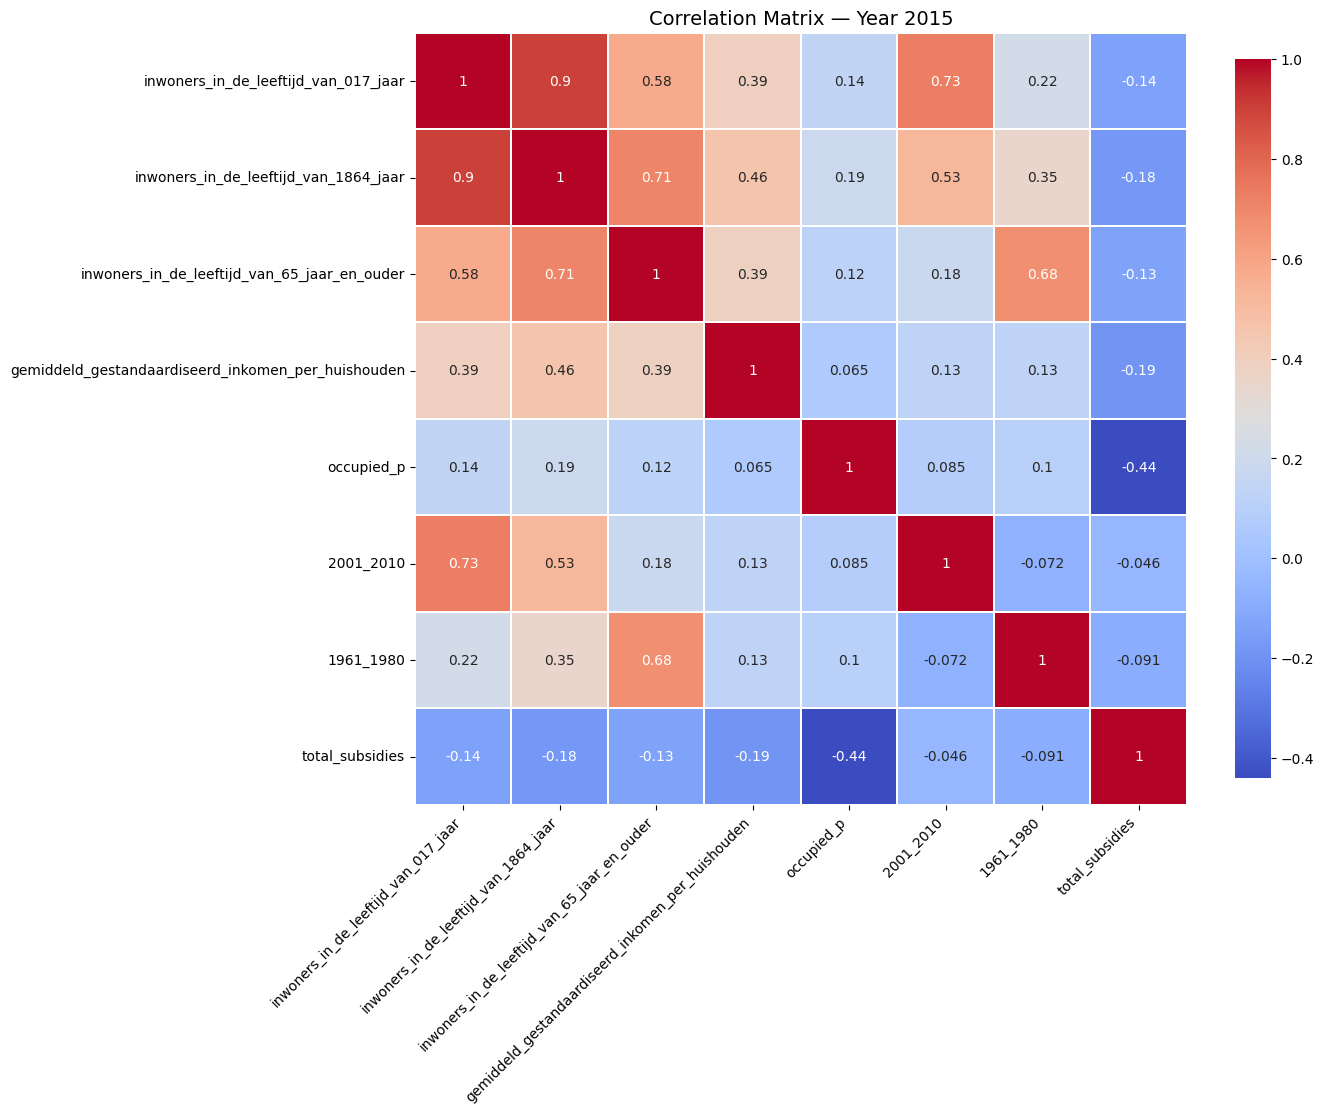


 Year: 2016

 VIF Values:


Feature          VIF
0                                              const  3125.333795
1               inwoners_in_de_leeftijd_van_017_jaar    12.734934
2              inwoners_in_de_leeftijd_van_1864_jaar     8.096932
8  Aantal geregistreerde installaties met zonnepa...     5.483911
3       inwoners_in_de_leeftijd_van_65_jaar_en_ouder     4.303889
6                                          2001_2010     3.005031
7                                          1961_1980     2.194551
4  gemiddeld_gestandaardiseerd_inkomen_per_huisho...     1.407192
9                                    total_subsidies     1.168870
5                                         occupied_p     1.098224

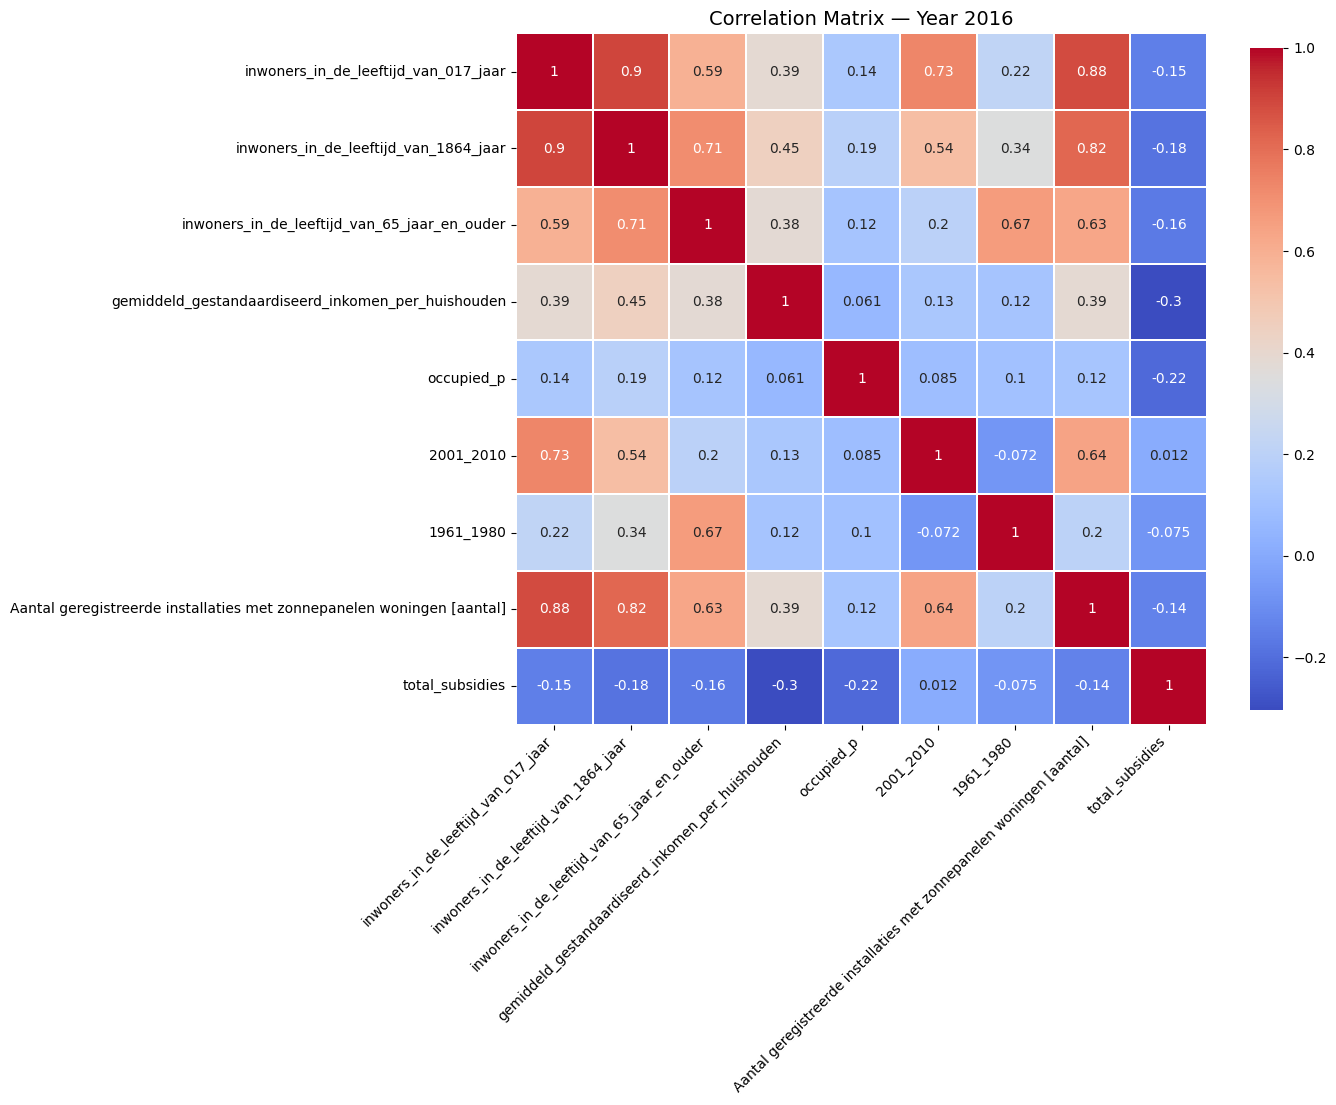


 Year: 2017

 VIF Values:


Feature          VIF
0                                               const  3522.572829
1                inwoners_in_de_leeftijd_van_017_jaar    10.972244
2               inwoners_in_de_leeftijd_van_1864_jaar     8.030821
6                                           2001_2010     6.365521
8   Aantal woningen met elektrische verwarming (be...     5.364403
9   Aantal geregistreerde installaties met zonnepa...     4.810764
3        inwoners_in_de_leeftijd_van_65_jaar_en_ouder     4.023917
7                                           1961_1980     2.075525
4   gemiddeld_gestandaardiseerd_inkomen_per_huisho...     1.341267
10                                    total_subsidies     1.239425
5                                          occupied_p     1.232574

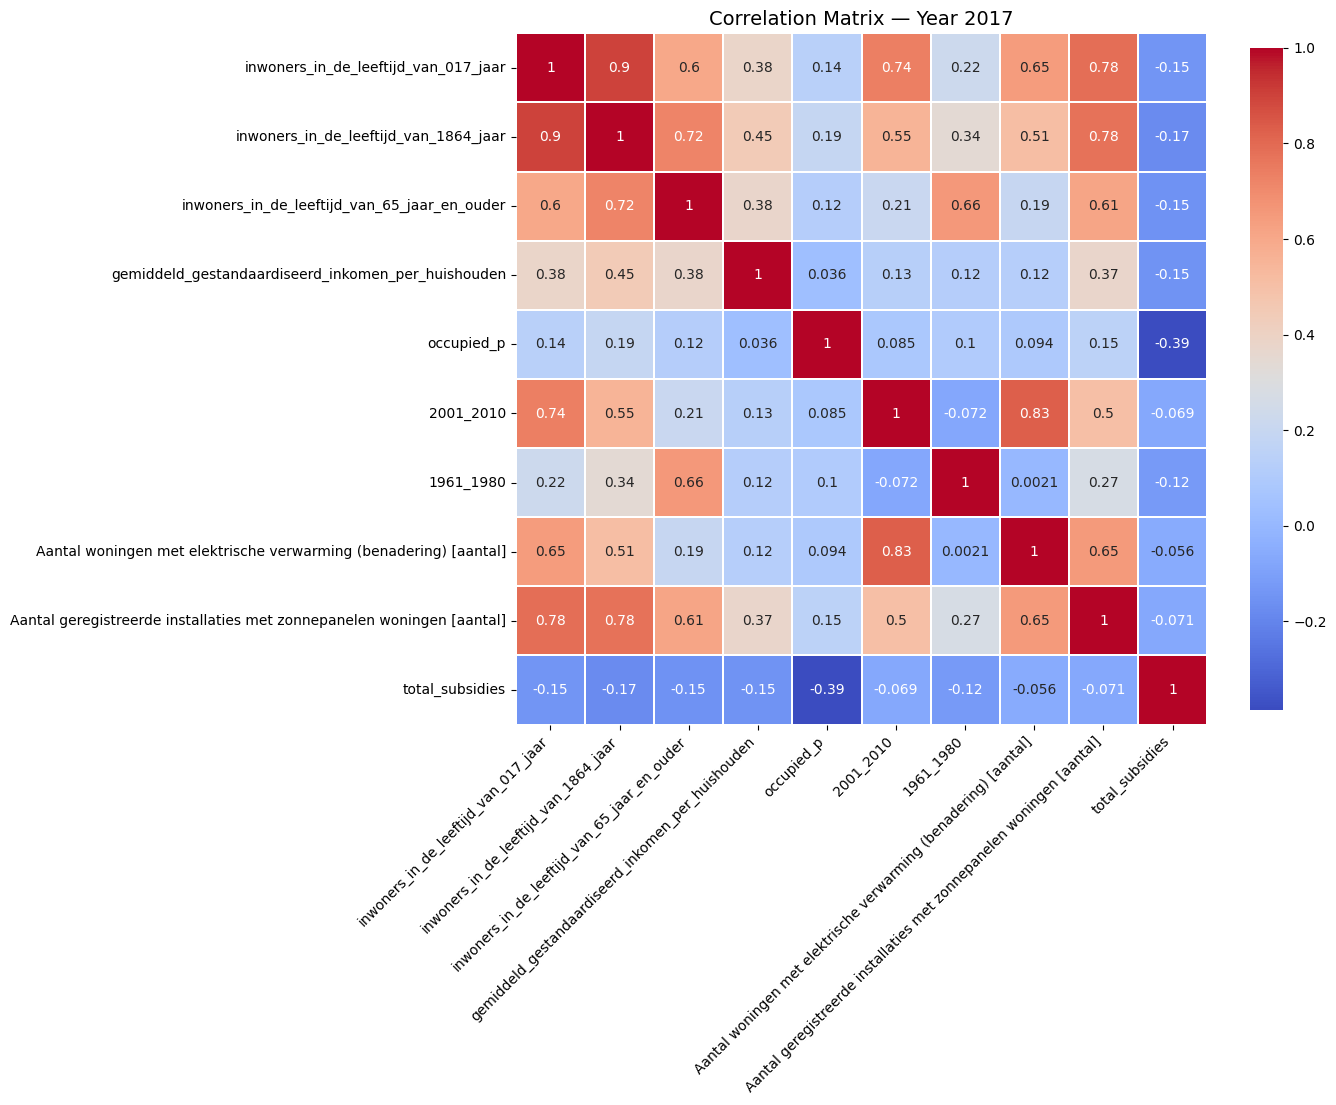


 Year: 2018

 VIF Values:


Feature          VIF
0                                               const  3084.181547
1                inwoners_in_de_leeftijd_van_017_jaar     9.393992
2               inwoners_in_de_leeftijd_van_1864_jaar     7.660804
6                                           2001_2010     3.885464
3        inwoners_in_de_leeftijd_van_65_jaar_en_ouder     3.576783
9   Aantal geregistreerde installaties met zonnepa...     2.600728
7                                           1961_1980     2.219214
8   Aantal woningen met elektrische verwarming (be...     1.895710
4   gemiddeld_gestandaardiseerd_inkomen_per_huisho...     1.408460
10                                    total_subsidies     1.223077
5                                          occupied_p     1.082548

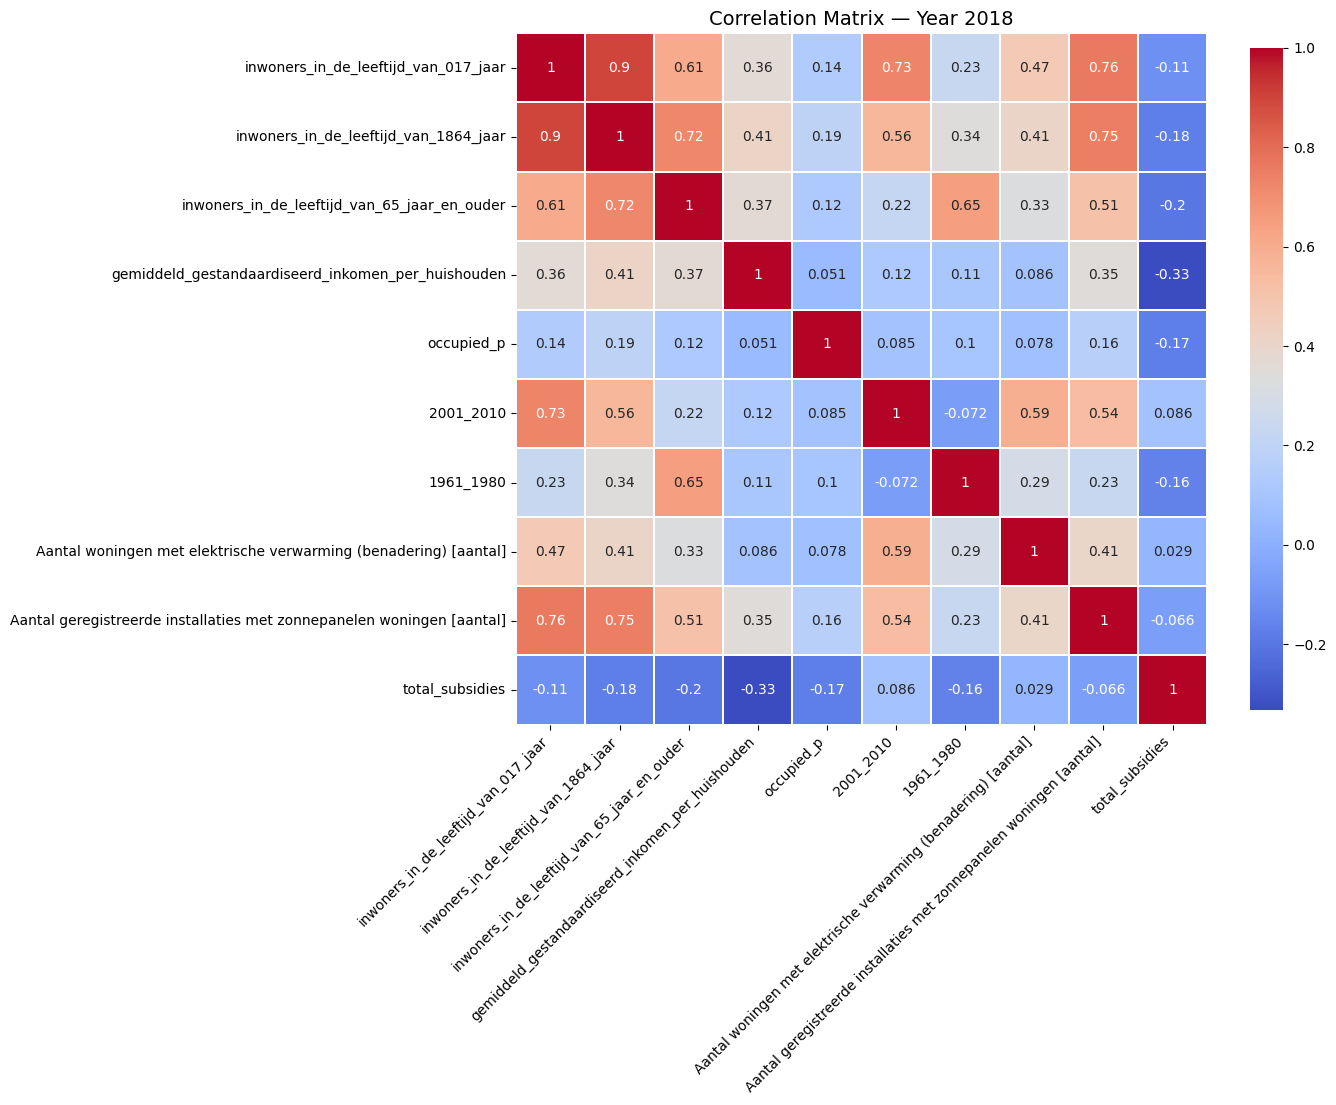


 Year: 2019

 VIF Values:


Feature          VIF
0                                               const  3492.835318
1                inwoners_in_de_leeftijd_van_017_jaar    19.784642
9   Aantal geregistreerde installaties met zonnepa...     9.361309
2               inwoners_in_de_leeftijd_van_1864_jaar     7.684700
3        inwoners_in_de_leeftijd_van_65_jaar_en_ouder     3.858228
6                                           2001_2010     3.752995
7                                           1961_1980     2.303255
8   Aantal woningen met elektrische verwarming (be...     1.898491
4   gemiddeld_gestandaardiseerd_inkomen_per_huisho...     1.260422
5                                          occupied_p     1.217898
10                                    total_subsidies     1.213754

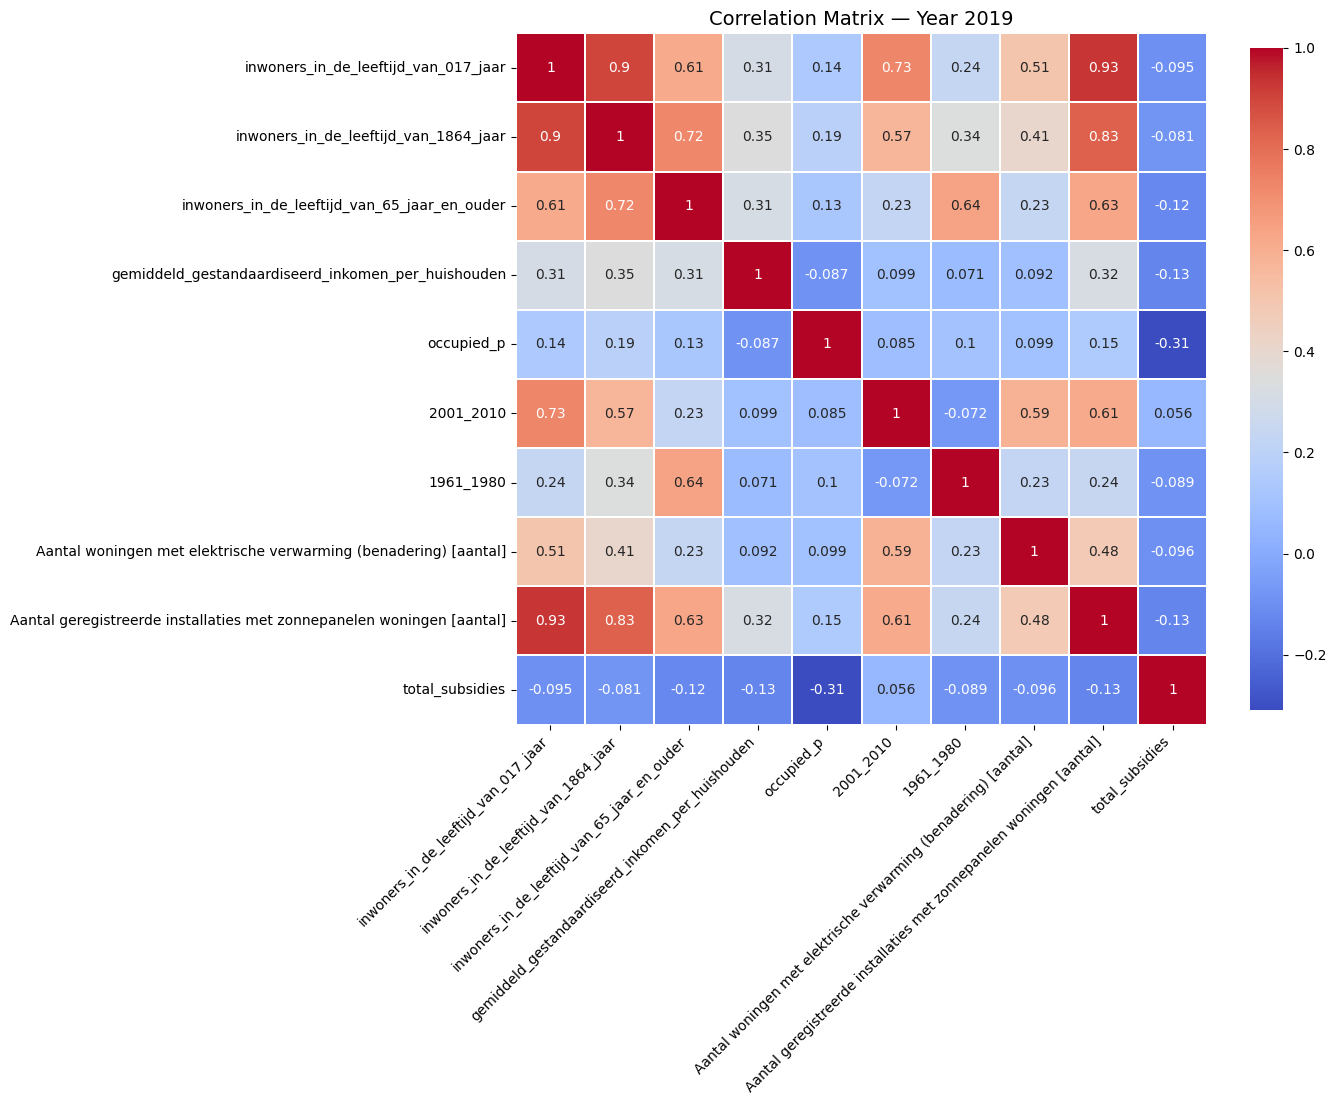


 Year: 2020

 VIF Values:


Feature          VIF
0                                               const  3117.914516
1                inwoners_in_de_leeftijd_van_017_jaar    16.905653
9   Aantal geregistreerde installaties met zonnepa...     9.874019
2               inwoners_in_de_leeftijd_van_1864_jaar     7.669402
3        inwoners_in_de_leeftijd_van_65_jaar_en_ouder     4.008307
6                                           2001_2010     3.322037
7                                           1961_1980     2.213228
8   Aantal woningen met elektrische verwarming (be...     1.836823
4   gemiddeld_gestandaardiseerd_inkomen_per_huisho...     1.280351
10                                    total_subsidies     1.164797
5                                          occupied_p     1.093726

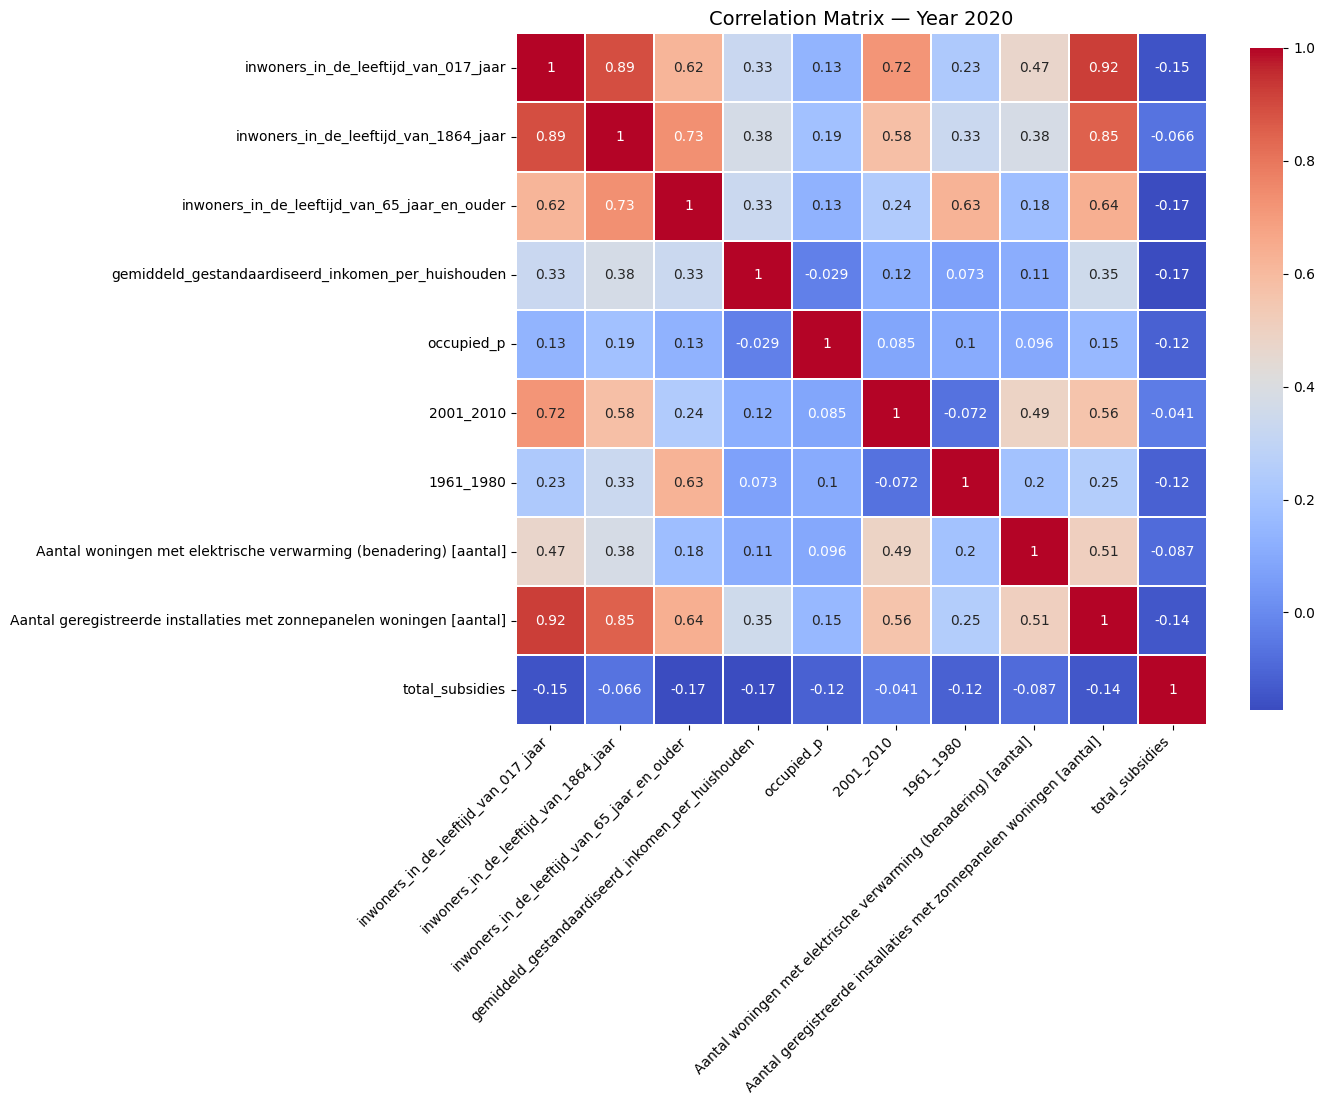


 Year: 2021

 VIF Values:


Feature          VIF
0                                               const  3100.187639
1                inwoners_in_de_leeftijd_van_017_jaar    14.373269
9   Aantal geregistreerde installaties met zonnepa...     9.179111
2               inwoners_in_de_leeftijd_van_1864_jaar     7.050847
3        inwoners_in_de_leeftijd_van_65_jaar_en_ouder     5.244070
6                                           2001_2010     3.033294
10                                    total_subsidies     2.714596
7                                           1961_1980     2.008485
8   Aantal woningen met elektrische verwarming (be...     1.796013
4   gemiddeld_gestandaardiseerd_inkomen_per_huisho...     1.251248
5                                          occupied_p     1.092903

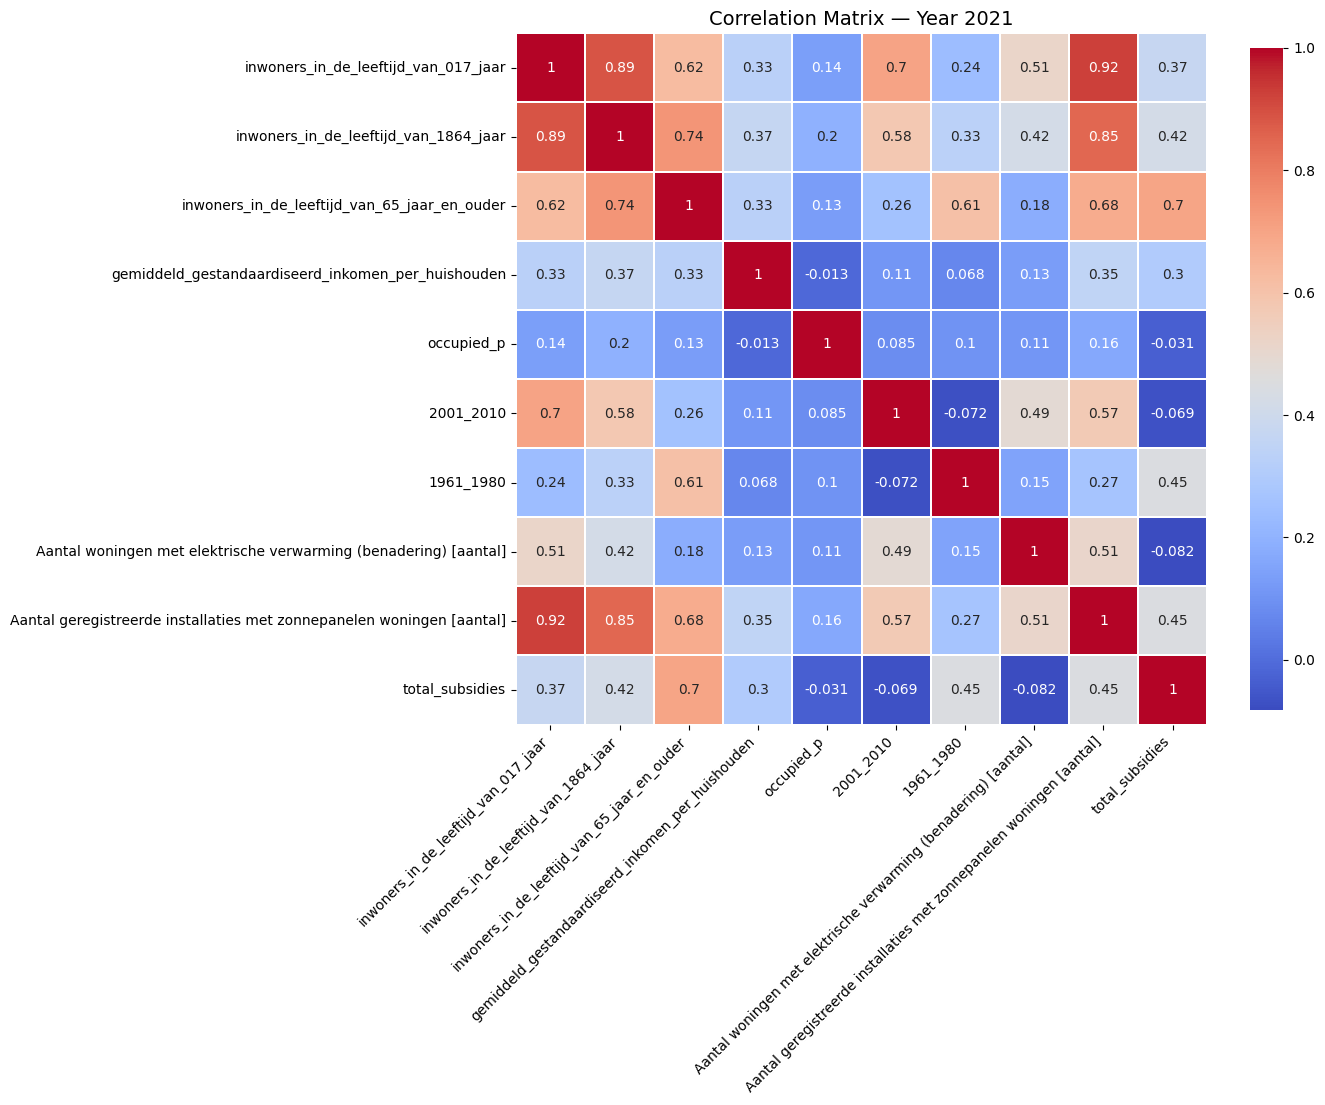


 Year: 2022

 VIF Values:


Feature          VIF
0                                              const  2970.676878
5  Aantal geregistreerde installaties met zonnepa...     5.001153
6                                    total_subsidies     3.019098
2                                          2001_2010     2.309823
4  Aantal woningen met elektrische verwarming (be...     1.883188
3                                          1961_1980     1.256088
1                                         occupied_p     1.048421

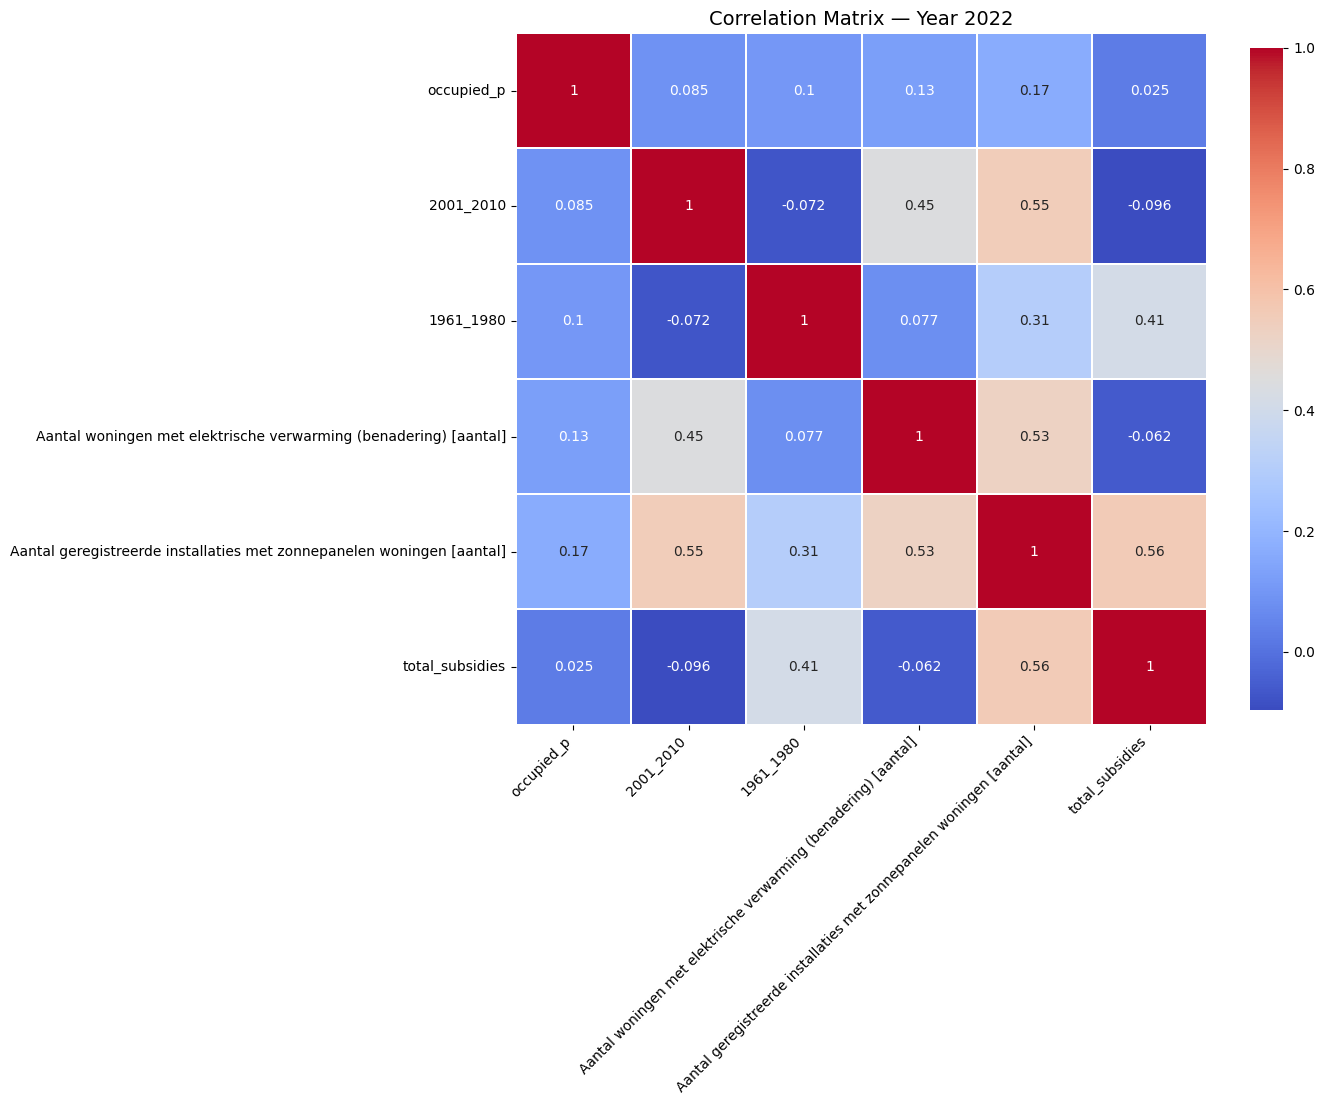


 Year: 2023

 VIF Values:


Feature          VIF
0                                              const  3089.152908
1               inwoners_in_de_leeftijd_van_017_jaar     8.916482
2              inwoners_in_de_leeftijd_van_1864_jaar     6.300959
3       inwoners_in_de_leeftijd_van_65_jaar_en_ouder     5.795266
9                                    total_subsidies     4.268600
6                                          2001_2010     3.332876
5                                  coaching_sessions     3.013677
7                                          1961_1980     2.180413
8  Aantal woningen met elektrische verwarming (be...     1.997433
4                                         occupied_p     1.093554

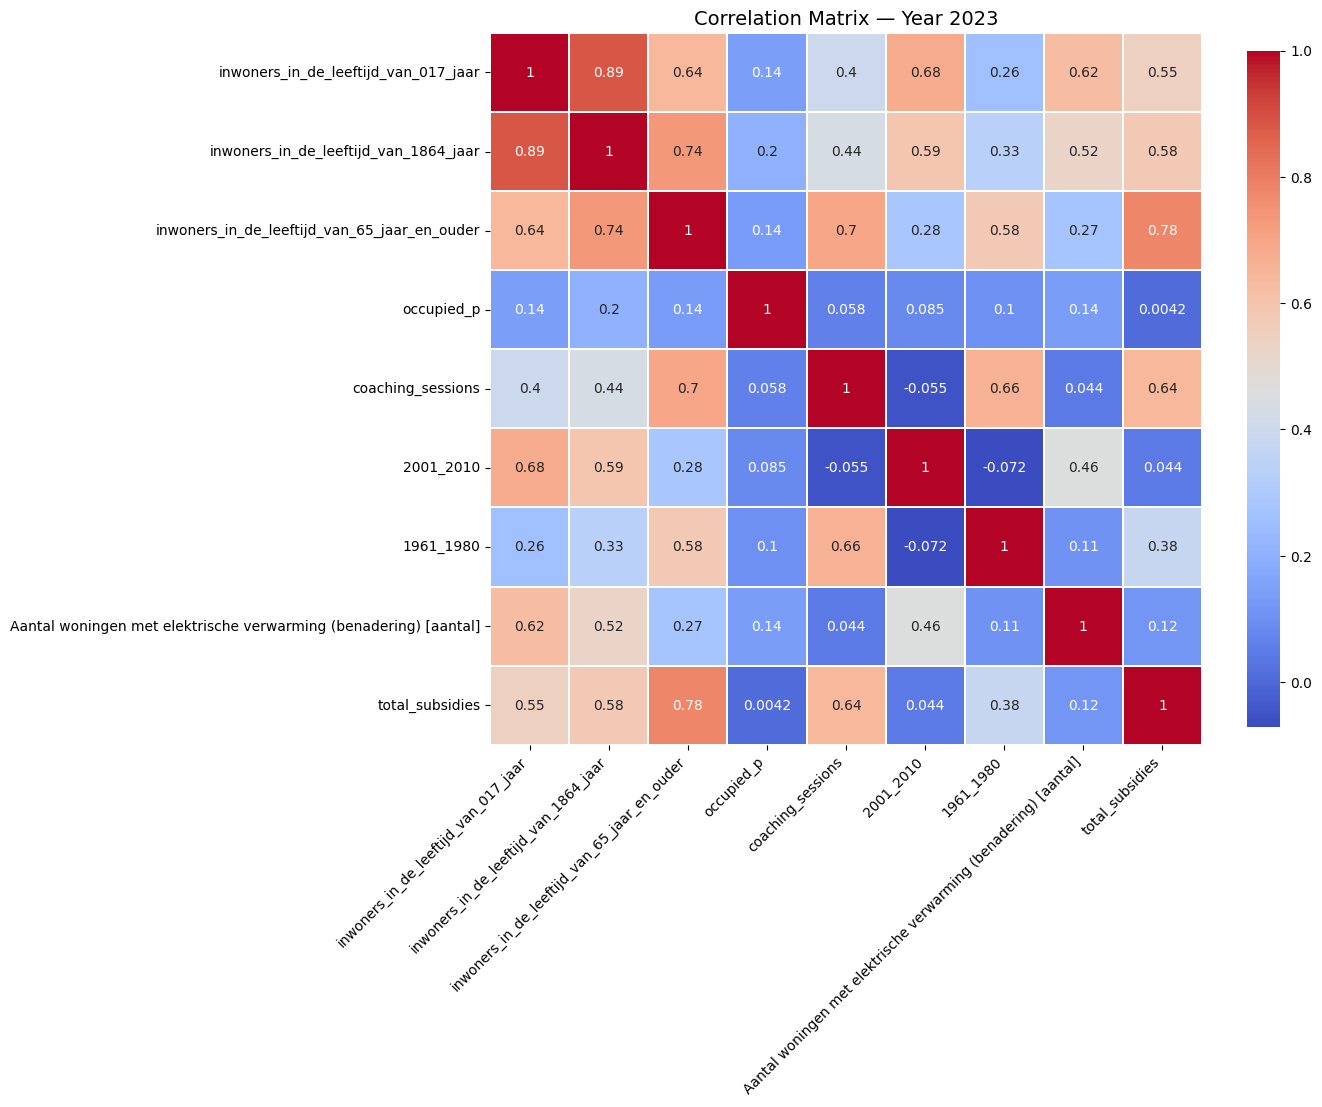

In [15]:

# Selected variables
selected_columns = [
    'inwoners_in_de_leeftijd_van_017_jaar',
    'inwoners_in_de_leeftijd_van_1864_jaar',
    'inwoners_in_de_leeftijd_van_65_jaar_en_ouder',
    'gemiddeld_gestandaardiseerd_inkomen_per_huishouden',
    'occupied_p',
    #'unoccupied',
    'coaching_sessions',
    '2001_2010',
    '1961_1980',
    'Consumentenprijs gas (variabele kosten incl. energiebelasting en BTW) [€]',
    'Consumentenprijs elektriciteit (variabele kosten incl. energiebelasting en BTW) [€]',
    'Aantal woningen met elektrische verwarming (benadering) [aantal]',
    'Aantal geregistreerde installaties met zonnepanelen woningen [aantal]',
    'total_subsidies'
]

# Loop per year
years = sorted([y for y in merged['year'].dropna().unique() if y < 2024])

for yr in years:
    print(f"\n Year: {int(yr)}")

    # Load and clean data
    data = merged[merged['year'] == yr][selected_columns].copy()
    data.dropna(inplace=True)
    data = data.loc[:, data.nunique() > 1]

    if data.shape[1] < 2:
        print("Not enough usable variables.\n")
        continue

    # VIF Calculation
    X = sm.add_constant(data)
    vif = pd.DataFrame()
    vif["Feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.sort_values(by="VIF", ascending=False)

    print("\n VIF Values:")
    display(vif)

    # Correlation Matrix 
    corr = data.corr()

    plt.figure(figsize=(14, 12))  

    sns.heatmap(
        corr,
        annot=True,
        cmap='coolwarm',
        square=True,
        linewidths=0.3,
        cbar_kws={"shrink": 0.8}
    )
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(f"Correlation Matrix — Year {int(yr)}", fontsize=14)
    plt.tight_layout()
    plt.show()


## Dropped variables

In [16]:

# SETTINGS
vif_threshold = 10
corr_threshold = 0.9

# Updated selected variables
selected_columns = [
   'inwoners_in_de_leeftijd_van_017_jaar',
    'inwoners_in_de_leeftijd_van_1864_jaar',
    'inwoners_in_de_leeftijd_van_65_jaar_en_ouder',
    'gemiddeld_gestandaardiseerd_inkomen_per_huishouden',
    'occupied_p',
    #'unoccupied',
    'coaching_sessions',
    '2001_2010',
    '1961_1980',
    'Consumentenprijs gas (variabele kosten incl. energiebelasting en BTW) [€]',
    'Consumentenprijs elektriciteit (variabele kosten incl. energiebelasting en BTW) [€]',
    'Aantal woningen met elektrische verwarming (benadering) [aantal]',
    'Aantal geregistreerde installaties met zonnepanelen woningen [aantal]',
    'total_subsidies']

# Always keep these
always_keep = ['total_subsidies']

# Loop per year(use less than 2024 because we are not using 2024 and 2025 dataset)
years = sorted([y for y in merged['year'].dropna().unique() if y < 2024])

for yr in years:
    print(f"\nYear: {int(yr)}")

    # Load and filter data
    data = merged[merged['year'] == yr][selected_columns].copy()
    data.dropna(inplace=True)
    
    # Drop constant columns
    data = data.loc[:, data.nunique() > 1]

    if data.shape[1] < 2:
        print("Not enough data for this year.\n")
        continue

    # Step 1: VIF Filtering
    X = sm.add_constant(data)
    vif = pd.DataFrame()
    vif["Feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.sort_values(by="VIF", ascending=False)

    high_vif = vif[vif["VIF"] > vif_threshold]["Feature"].tolist()
    high_vif = [col for col in high_vif if col not in always_keep and col != 'const']
    data.drop(columns=high_vif, inplace=True)

    # Step 2: Correlation Filtering
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop_corr = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    to_drop_corr = [col for col in to_drop_corr if col not in always_keep]
    data.drop(columns=to_drop_corr, inplace=True)

    # Output
    print(f" Dropped due to VIF > {vif_threshold}: {high_vif}")
    print(f" Dropped due to correlation > {corr_threshold}: {to_drop_corr}")
    print(f" Variables retained for modeling ({len(data.columns)}): {list(data.columns)}")



Year: 2015
 Dropped due to VIF > 10: ['inwoners_in_de_leeftijd_van_017_jaar']
 Dropped due to correlation > 0.9: []
 Variables retained for modeling (7): ['inwoners_in_de_leeftijd_van_1864_jaar', 'inwoners_in_de_leeftijd_van_65_jaar_en_ouder', 'gemiddeld_gestandaardiseerd_inkomen_per_huishouden', 'occupied_p', '2001_2010', '1961_1980', 'total_subsidies']

Year: 2016
 Dropped due to VIF > 10: ['inwoners_in_de_leeftijd_van_017_jaar']
 Dropped due to correlation > 0.9: []
 Variables retained for modeling (8): ['inwoners_in_de_leeftijd_van_1864_jaar', 'inwoners_in_de_leeftijd_van_65_jaar_en_ouder', 'gemiddeld_gestandaardiseerd_inkomen_per_huishouden', 'occupied_p', '2001_2010', '1961_1980', 'Aantal geregistreerde installaties met zonnepanelen woningen [aantal]', 'total_subsidies']

Year: 2017
 Dropped due to VIF > 10: ['inwoners_in_de_leeftijd_van_017_jaar']
 Dropped due to correlation > 0.9: []
 Variables retained for modeling (9): ['inwoners_in_de_leeftijd_van_1864_jaar', 'inwoners_in_d

### Now,going ahead to choose the  dependent vs independent variables.Noting in  mind that the goal of the project is to analyze how gas consumption,  are influenced by coaching and subsiides in conjuction with other variables, accounting for spatial variation across neighborhoods.  



## Prepare Data for GWR 

We define our dependent variable (gas consumption), predictor variables , and coordinates for spatial modeling. Data is filtered, standardized, and preprocessed for compatibility with the GWR model.



In [17]:


# Years to prepare 
years_to_prepare = list(range(2015, 2024))

#  Variables retained by VIF/correlation filtering 
retained_by_year = {
    2015: [
        'inwoners_in_de_leeftijd_van_1864_jaar', 
        'inwoners_in_de_leeftijd_van_65_jaar_en_ouder', 
        'gemiddeld_gestandaardiseerd_inkomen_per_huishouden', 
        '2001_2010', 
        '1961_1980', 
        'total_subsidies',
        'occupied_p'
    ],
    2016: [
        'inwoners_in_de_leeftijd_van_1864_jaar', 
        'inwoners_in_de_leeftijd_van_65_jaar_en_ouder', 
        'gemiddeld_gestandaardiseerd_inkomen_per_huishouden', 
        '2001_2010', 
        '1961_1980', 
        'Aantal geregistreerde installaties met zonnepanelen woningen [aantal]', 
        'total_subsidies',
        'occupied_p'
    ],
    2017: [
        'inwoners_in_de_leeftijd_van_1864_jaar', 
        'inwoners_in_de_leeftijd_van_65_jaar_en_ouder', 
        'gemiddeld_gestandaardiseerd_inkomen_per_huishouden', 
        '2001_2010', 
        '1961_1980', 
        'Aantal woningen met elektrische verwarming (benadering) [aantal]', 
        'Aantal geregistreerde installaties met zonnepanelen woningen [aantal]', 
        'total_subsidies',
        'occupied_p'
    ],
    2018: [
        'inwoners_in_de_leeftijd_van_017_jaar', 
        'inwoners_in_de_leeftijd_van_1864_jaar', 
        'inwoners_in_de_leeftijd_van_65_jaar_en_ouder', 
        'gemiddeld_gestandaardiseerd_inkomen_per_huishouden', 
        '2001_2010', 
        '1961_1980', 
        'Aantal woningen met elektrische verwarming (benadering) [aantal]', 
        'Aantal geregistreerde installaties met zonnepanelen woningen [aantal]', 
        'total_subsidies',
        'occupied_p'
    ],
    2019: [
        'inwoners_in_de_leeftijd_van_1864_jaar', 
        'inwoners_in_de_leeftijd_van_65_jaar_en_ouder', 
        'gemiddeld_gestandaardiseerd_inkomen_per_huishouden', 
        '2001_2010', 
        '1961_1980', 
        'Aantal woningen met elektrische verwarming (benadering) [aantal]', 
        'Aantal geregistreerde installaties met zonnepanelen woningen [aantal]', 
        'total_subsidies',
        'occupied_p'
    ],
    2020: [
        'inwoners_in_de_leeftijd_van_1864_jaar', 
        'inwoners_in_de_leeftijd_van_65_jaar_en_ouder', 
        'gemiddeld_gestandaardiseerd_inkomen_per_huishouden', 
        '2001_2010', 
        '1961_1980', 
        'Aantal woningen met elektrische verwarming (benadering) [aantal]', 
        'Aantal geregistreerde installaties met zonnepanelen woningen [aantal]', 
        'total_subsidies',
        'occupied_p'
    ],
    2021: [
        'inwoners_in_de_leeftijd_van_1864_jaar', 
        'inwoners_in_de_leeftijd_van_65_jaar_en_ouder', 
        'gemiddeld_gestandaardiseerd_inkomen_per_huishouden', 
        '2001_2010', 
        '1961_1980', 
        'Aantal woningen met elektrische verwarming (benadering) [aantal]', 
        'Aantal geregistreerde installaties met zonnepanelen woningen [aantal]', 
        'total_subsidies',
        'occupied_p'
    ],
    2022: [
        '2001_2010', 
        '1961_1980', 
        'Aantal woningen met elektrische verwarming (benadering) [aantal]', 
        'Aantal geregistreerde installaties met zonnepanelen woningen [aantal]', 
        'total_subsidies',
        'occupied_p'
    ],
    2023: [
        'inwoners_in_de_leeftijd_van_017_jaar', 
        'inwoners_in_de_leeftijd_van_1864_jaar', 
        'inwoners_in_de_leeftijd_van_65_jaar_en_ouder', 
        'coaching_sessions', 
        '2001_2010', 
        '1961_1980', 
        'Aantal woningen met elektrische verwarming (benadering) [aantal]', 
        'total_subsidies',
        'occupied_p'
    ]
}

#  Store GWR-ready data per year 
gwr_data_by_year = {}

for year in years_to_prepare:
    data_year = merged[merged["year"] == year].copy().reset_index(drop=True)
    if data_year.empty:
        print(f" No data for year {year}. Skipping.")
        continue

    if year not in retained_by_year:
        print(f" No filtered variables listed for year {year}. Skipping.")
        continue

    target = "gas_consumption_TJ"
    coords = data_year[["latitude", "longitude"]].values

    # Exclude target and electricity from predictors
    predictors = [v for v in retained_by_year[year] if v not in [target, 'electricity_consumption_GWh']]

    # Split into policy and control vars
    policy_vars = [v for v in predictors if 'subsidy' in v.lower() or 'subsidies' in v.lower() or 'coaching' in v.lower()]
    control_vars = [v for v in predictors if v not in policy_vars]

    # Prepare feature matrix and target
    X = data_year[predictors].copy()
    y = data_year[[target]].values

    # Convert object columns to numeric
    for col in X.select_dtypes(include="object").columns:
        X[col] = pd.to_numeric(X[col], errors="coerce")

    # Fill NA in policy vars, drop rows with NA elsewhere
    if policy_vars:
        X[policy_vars] = X[policy_vars].fillna(0)
    X = X.dropna()
    y = y[X.index.to_numpy()]
    coords = coords[X.index.to_numpy()]

    if 'total_subsidies' not in X.columns:
        print(f" Warning: 'total_subsidies' not found in final X for year {year}!")

    if len(X) < 30:
        print(f" Not enough data for year {year}. Skipping.")
        continue

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Store processed year
    gwr_data_by_year[year] = {
        "X": X,
        "X_standardized": X_scaled,
        "y": y,
        "coords": coords,
        "included_policy_vars": policy_vars,
        "feature_names": list(X.columns)
    }

    print(f" Prepared {year} — included policies: {policy_vars}")

print(" Done preparing GWR data for all valid years!")


 Prepared 2015 — included policies: ['total_subsidies']
 Prepared 2016 — included policies: ['total_subsidies']
 Prepared 2017 — included policies: ['total_subsidies']
 Prepared 2018 — included policies: ['total_subsidies']
 Prepared 2019 — included policies: ['total_subsidies']
 Prepared 2020 — included policies: ['total_subsidies']
 Prepared 2021 — included policies: ['total_subsidies']
 Prepared 2022 — included policies: ['total_subsidies']
 Prepared 2023 — included policies: ['coaching_sessions', 'total_subsidies']
 Done preparing GWR data for all valid years!


## Run Geographically Weighted Regression (GWR)

Here, we execute the GWR model using the selected year and preprocessed inputs. We extract model diagnostics and local coefficients to understand the spatial heterogeneity of gas usage drivers.

### The kernel method was chosen based on the factors below:
- modeling neighborhood-level data (buurten in Zwolle).

- discrete spatial units (not continuous points).

- variables include social, demographic, and building-related features.

- coordinates come from centroids of neighborhoods, not individual buildings.

In [18]:

#  Store GWR effect summaries per year 
all_effects = {}

for year in sorted(gwr_data_by_year.keys()):
    print(f"\n Running GWR for year {year}...")

    # Unpack standardized features and meta info
    X_standardized = gwr_data_by_year[year]["X_standardized"]
    feature_names = gwr_data_by_year[year]["feature_names"]
    y = gwr_data_by_year[year]["y"]
    coords = gwr_data_by_year[year]["coords"]
    policy_vars = gwr_data_by_year[year].get("included_policy_vars", [])

    try:
        # Step 1: Bandwidth selection
        bw = Sel_BW(coords, y, X_standardized, kernel='bisquare', fixed=False).search()

        # Step 2: Fit GWR model
        model = GWR(coords, y, X_standardized, bw, kernel='bisquare', fixed=False)
        results = model.fit()

        # Save model results into gwr_data_by_year
        gwr_data_by_year[year]["results"] = results

        # Step 3: Summarize policy variable effects
        effect_summaries = {}

        for i, var in enumerate(feature_names):
            if var == 'electricity_consumption_GWh':  # skip if included accidentally
                continue

            if var in policy_vars:
                local_coefs = results.params[:, i + 1]  # index +1 due to intercept
                effect_summaries[var] = {
                    "mean": float(np.mean(local_coefs)),
                    "min": float(np.min(local_coefs)),
                    "max": float(np.max(local_coefs)),
                    "std": float(np.std(local_coefs))
                }

        all_effects[year] = effect_summaries

        # Step 4: Print summary
        print("\n Policy Effect Summary:")
        for var, stats in effect_summaries.items():
            print(f"  {var}: {stats}")

        print("\n GWR Model Summary:")
        print(results.summary())

    except Exception as e:
        print(f" GWR failed for year {year}: {e}")
        all_effects[year] = {"error": str(e)}

print("\n GWR run complete for all available years.")



 Running GWR for year 2015...

 Policy Effect Summary:
  total_subsidies: {'mean': -0.06461794054729755, 'min': -0.5924030493433523, 'max': 0.2949912591213188, 'std': 0.28861374206941454}

 GWR Model Summary:
Model type                                                         Gaussian
Number of observations:                                                  78
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1736.151
Log-likelihood:                                                    -231.683
AIC:                                                                479.366
AICc:                                                               484.013
BIC:                                                               1431.182
R2:                                                                   0.961
Adj

## How are variables defined?

In [19]:
#  Show variable mappings used in the model
print("\nGWR Variable Mapping by Year:")
for year, data in gwr_data_by_year.items():
    X = data["X"]
    used_vars = X.columns.tolist()
    print(f"\nYear {year}:")
    for i, var in enumerate(used_vars):
        print(f"   X{i}: {var}")




GWR Variable Mapping by Year:

Year 2015:
   X0: inwoners_in_de_leeftijd_van_1864_jaar
   X1: inwoners_in_de_leeftijd_van_65_jaar_en_ouder
   X2: gemiddeld_gestandaardiseerd_inkomen_per_huishouden
   X3: 2001_2010
   X4: 1961_1980
   X5: total_subsidies
   X6: occupied_p

Year 2016:
   X0: inwoners_in_de_leeftijd_van_1864_jaar
   X1: inwoners_in_de_leeftijd_van_65_jaar_en_ouder
   X2: gemiddeld_gestandaardiseerd_inkomen_per_huishouden
   X3: 2001_2010
   X4: 1961_1980
   X5: Aantal geregistreerde installaties met zonnepanelen woningen [aantal]
   X6: total_subsidies
   X7: occupied_p

Year 2017:
   X0: inwoners_in_de_leeftijd_van_1864_jaar
   X1: inwoners_in_de_leeftijd_van_65_jaar_en_ouder
   X2: gemiddeld_gestandaardiseerd_inkomen_per_huishouden
   X3: 2001_2010
   X4: 1961_1980
   X5: Aantal woningen met elektrische verwarming (benadering) [aantal]
   X6: Aantal geregistreerde installaties met zonnepanelen woningen [aantal]
   X7: total_subsidies
   X8: occupied_p

Year 2018:
   X0

##  Mapping Residuals from GWR (Observed – Predicted)

This section evaluates the performance of the GWR model by mapping the spatial distribution of residuals — the difference between observed and predicted gas consumption — for each year. 

The goal is to visually and statistically check whether the errors are randomly distributed, or if there are unexplained spatial patterns remaining in the model.


 




In [20]:

# Load the Zwolle shapefile
shapefile_path = "Buurtgrenzen_Zwolle.shp"
gdf_buurt = gpd.read_file(shapefile_path)

# Rename OFFICIËLE to match your other datass
gdf_buurt['buurt_naam'] = gdf_buurt['OFFICIËLE'].str.strip().str.lower()

# Set CRS to WGS84 (lat/lon)
gdf_buurt = gdf_buurt.to_crs("EPSG:4326")



 Processing residuals for year 2015...
   Moran’s I: 0.047 | p = 0.1870

 Processing residuals for year 2016...
   Moran’s I: -0.042 | p = 0.3600

 Processing residuals for year 2017...
   Moran’s I: 0.046 | p = 0.2190

 Processing residuals for year 2018...
   Moran’s I: 0.029 | p = 0.2930

 Processing residuals for year 2019...
   Moran’s I: -0.050 | p = 0.3350

 Processing residuals for year 2020...
   Moran’s I: -0.043 | p = 0.3320

 Processing residuals for year 2021...
   Moran’s I: -0.008 | p = 0.4570

 Processing residuals for year 2022...
   Moran’s I: 0.166 | p = 0.0200

 Processing residuals for year 2023...
   Moran’s I: 0.010 | p = 0.3860


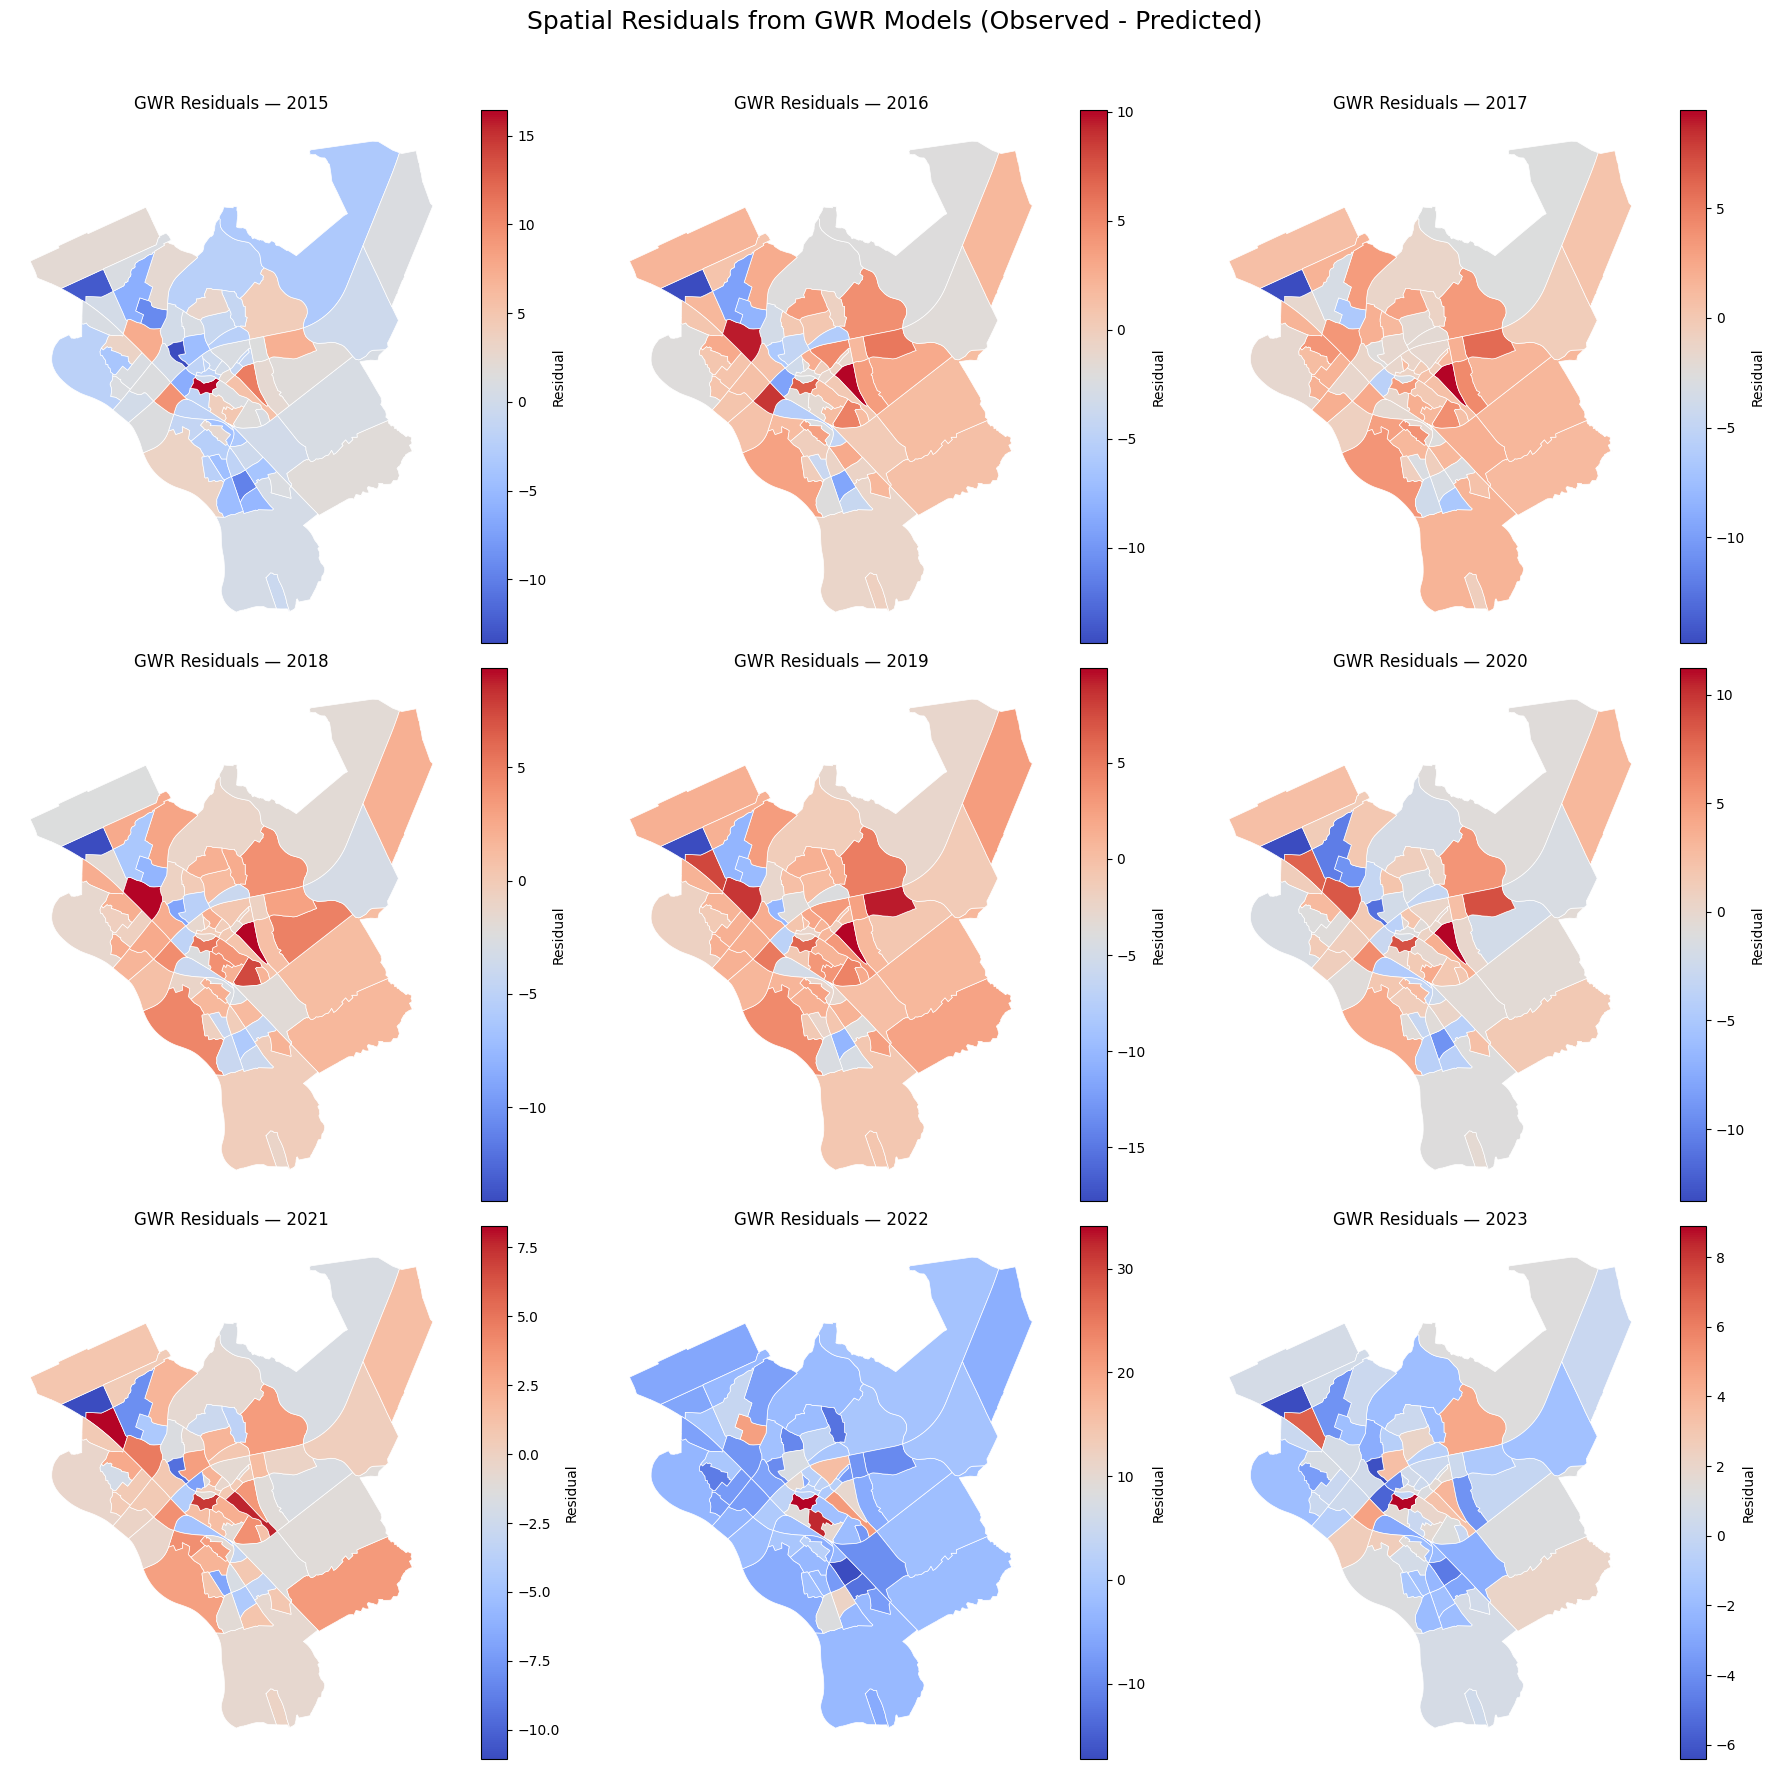

In [21]:
###  Mapping Errors (Residuals) After GWR — Grid View


#  Store residual maps per year
residual_maps = {}

#  Loop through GWR years
for year, gwr_entry in gwr_data_by_year.items():
    if gwr_entry.get("results") is None:
        print(f" Skipping year {year} (no GWR results)")
        continue

    print(f"\n Processing residuals for year {year}...")

    y = gwr_entry["y"]
    coords = gwr_entry["coords"]
    results = gwr_entry["results"]

    residuals = y.flatten() - results.predy.flatten()
    gwr_data_by_year[year]["residuals"] = residuals

    # Create GeoDataFrame
    residual_df = pd.DataFrame({
        "latitude": coords[:, 0],
        "longitude": coords[:, 1],
        "residual": residuals
    })
    residual_gdf = gpd.GeoDataFrame(
        residual_df,
        geometry=gpd.points_from_xy(residual_df.longitude, residual_df.latitude),
        crs="EPSG:4326"
    )

    # Join with neighborhood shapes
    joined = gpd.sjoin(residual_gdf, gdf_buurt, how="left", predicate="within")

    # Aggregate residuals
    resid_summary = joined.groupby("buurt_naam").agg({
        "residual": "mean"
    }).reset_index()

    gdf_resid_map = gdf_buurt.merge(resid_summary, on="buurt_naam", how="left")

    # Moran's I
    w = Queen.from_dataframe(gdf_resid_map)
    w.transform = 'r'
    moran = Moran(gdf_resid_map["residual"].fillna(0), w)

    print(f"   Moran’s I: {moran.I:.3f} | p = {moran.p_sim:.4f}")

    # Save for grid plotting
    residual_maps[year] = {
        "gdf": gdf_resid_map,
        "vmin": gdf_resid_map["residual"].min(),
        "vmax": gdf_resid_map["residual"].max()
    }

#  Plot all residual maps in a grid
n_cols = 3
n_rows = int(np.ceil(len(residual_maps) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 6))
axes = axes.flatten()

for i, (year, data) in enumerate(sorted(residual_maps.items())):
    ax = axes[i]
    gdf = data["gdf"]
    vmin = data["vmin"]
    vmax = data["vmax"]

    gdf.plot(
        column="residual",
        cmap="coolwarm",
        edgecolor="white",
        linewidth=0.5,
        legend=True,
        legend_kwds={"label": "Residual"},
        vmin=vmin,
        vmax=vmax,
        ax=ax,
        missing_kwds={"color": "lightgrey"}
    )

    ax.set_title(f"GWR Residuals — {year}", fontsize=12)
    ax.axis("off")

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle("Spatial Residuals from GWR Models (Observed - Predicted)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Visualization

## Load the neighbourhood shapefile

In [22]:

# Load the Zwolle shapefile
shapefile_path = "Buurtgrenzen_Zwolle.shp"
gdf_buurt = gpd.read_file(shapefile_path)

# Rename OFFICIËLE to match your other datass
gdf_buurt['buurt_naam'] = gdf_buurt['OFFICIËLE'].str.strip().str.lower()

# Set CRS to WGS84 (lat/lon)
gdf_buurt = gdf_buurt.to_crs("EPSG:4326")


## Visualize Subsidies and Coaching Effects on Gas Use 

We visualize the spatial distribution of the coaching effect and subsides using a choropleth map. Neighborhoods are shaded according to the strength of the coaching effect on gas consumption, helping reveal local impact patterns.

## Overlay Coaching Sessions on Coaching Effect Map

To enhance interpretability, we overlay the number of coaching sessions per neighborhood as scaled bubbles. This map combines coaching activity with its estimated impact, providing both reach and effect dimensions.



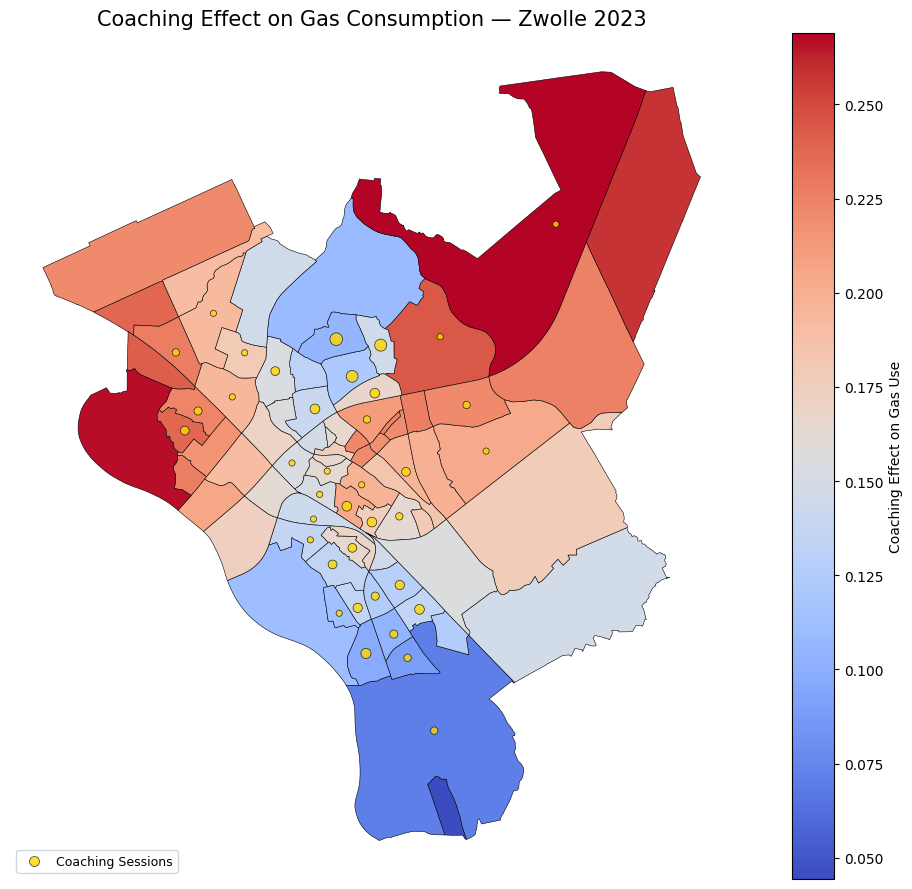

In [23]:
# Only run for 2023 (coaching was only offered that year) 
year = 2023
gwr_entry = gwr_data_by_year.get(year)

if gwr_entry and "coaching_sessions" in gwr_entry["X"].columns:

    X = gwr_entry["X"]
    y = gwr_entry["y"]
    coords = gwr_entry["coords"]
    results = gwr_entry["results"]

    # Get index of 'coaching_sessions' and extract local effects
    coaching_index = list(X.columns).index("coaching_sessions") + 1  # skip intercept
    local_coefs = results.params[:, coaching_index]

    # GWR output dataframe
    gwr_output = pd.DataFrame({
        "latitude": coords[:, 0],
        "longitude": coords[:, 1],
        "coaching_effect": local_coefs,
        "coaching_sessions": X["coaching_sessions"].values,
        "gas_consumption": y.flatten()
    })

    # Convert to GeoDataFrame
    gwr_gdf = gpd.GeoDataFrame(
        gwr_output,
        geometry=gpd.points_from_xy(gwr_output.longitude, gwr_output.latitude),
        crs="EPSG:4326"
    )

    # Spatial join with neighborhoods
    gwr_joined = gpd.sjoin(gwr_gdf, gdf_buurt, how="left", predicate="within")

    # Aggregate per neighborhood
    summary = gwr_joined.groupby("buurt_naam").agg({
        "coaching_effect": "mean",
        "coaching_sessions": "sum",
        "gas_consumption": "mean"
    }).reset_index()

    # Drop NaN coaching_effects (optional)
    summary = summary.dropna(subset=["coaching_effect"])

    # Merge with shapefile
    gdf_map = gdf_buurt.merge(summary, on="buurt_naam", how="left")

    # Generate centroids for bubble overlay
    gdf_map["centroid"] = gdf_map.geometry.representative_point()
    gdf_points = gdf_map.set_geometry("centroid")

    # Color scale based on actual coaching effect values
    vmin = gdf_map["coaching_effect"].min()
    vmax = gdf_map["coaching_effect"].max()

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))

    # Background: actual coaching effect
    gdf_map.plot(
        column="coaching_effect",
        cmap="coolwarm",
        legend=True,
        legend_kwds={"label": "Coaching Effect on Gas Use"},
        ax=ax,
        edgecolor="black",
        linewidth=0.4,
        vmin=vmin,
        vmax=vmax,
        missing_kwds={"color": "lightgrey", "label": "No data"}
    )

    # Bubbles: coaching sessions (sqrt-scaled for visual balance)
    bubble_layer = gdf_points[gdf_points["coaching_sessions"] > 0]
    bubble_layer.plot(
        ax=ax,
        markersize=np.sqrt(bubble_layer["coaching_sessions"]) * 20,  # tweak size factor if needed
        color="gold",
        edgecolor="black",
        linewidth=0.5,
        alpha=0.8,
        label="Coaching Sessions"
    )

    # Final polish
    ax.set_title("Coaching Effect on Gas Consumption — Zwolle 2023", fontsize=15)
    ax.axis("off")
    ax.legend(loc="lower left", fontsize=9, frameon=True)
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Coaching data not found for 2023.")


## Identify Target Areas for Future Coaching

We detect neighborhoods with high gas consumption but no coaching sessions in 2023. These areas are visualized to inform future intervention planning.


Identified 6 neighborhoods with high gas use and no coaching.


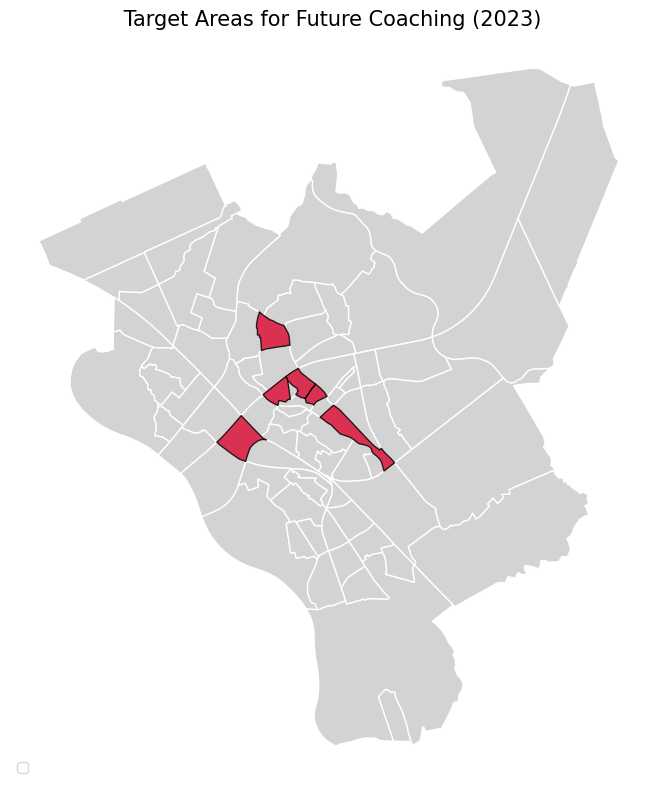

In [24]:
# Set target year
year = 2023

# Extract GWR entry
gwr_entry = gwr_data_by_year.get(year)
if gwr_entry is None:
    raise ValueError(f"No GWR data found for year {year}")
if "coaching_sessions" not in gwr_entry["X"].columns:
    raise ValueError(f"'coaching_sessions' not available in GWR data for {year}")
if gwr_entry.get("results") is None:
    raise ValueError(f"GWR results missing for year {year}")

# Unpack data
X = gwr_entry["X"]
y = gwr_entry["y"]
coords = gwr_entry["coords"]
results = gwr_entry["results"]

# Extract coaching coefficient
coaching_index = list(X.columns).index("coaching_sessions") + 1  # skip intercept
local_coefs = results.params[:, coaching_index]

# Build GWR output GeoDataFrame
gwr_output = pd.DataFrame({
    "latitude": coords[:, 0],
    "longitude": coords[:, 1],
    "coaching_effect": local_coefs,
    "coaching_sessions": X["coaching_sessions"].values,
    "gas_consumption": y.flatten()
})

gwr_gdf = gpd.GeoDataFrame(
    gwr_output,
    geometry=gpd.points_from_xy(gwr_output.longitude, gwr_output.latitude),
    crs="EPSG:4326"
)

# Spatial join with neighborhoods
joined = gpd.sjoin(gwr_gdf, gdf_buurt, how="left", predicate="within")

# Aggregate per neighborhood
summary = joined.groupby("buurt_naam").agg({
    "coaching_effect": "mean",
    "coaching_sessions": "sum",
    "gas_consumption": "mean"
}).reset_index()

# Identify target areas: no coaching, above-median gas use
threshold = summary["gas_consumption"].median()
target_areas = summary[
    (summary["coaching_sessions"] == 0) &
    (summary["gas_consumption"] > threshold)
].copy()

print(f"Identified {len(target_areas)} neighborhoods with high gas use and no coaching.")

# Merge with neighborhood geometries
gdf_target_areas = gdf_buurt.merge(target_areas, on="buurt_naam", how="inner")

# Plot results
fig, ax = plt.subplots(figsize=(10, 8))

# Background layer
gdf_buurt.plot(ax=ax, color="lightgrey", edgecolor="white")

# Highlight target areas
gdf_target_areas.plot(
    ax=ax,
    color="crimson",
    edgecolor="black",
    alpha=0.85,
    label="Target Neighborhoods"
)

# Polish plot
ax.set_title(" Target Areas for Future Coaching (2023)", fontsize=15)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)
plt.tight_layout()
plt.show()


## Subsidies effect map

The presence of the subsidies is mapped over the subsidies effect

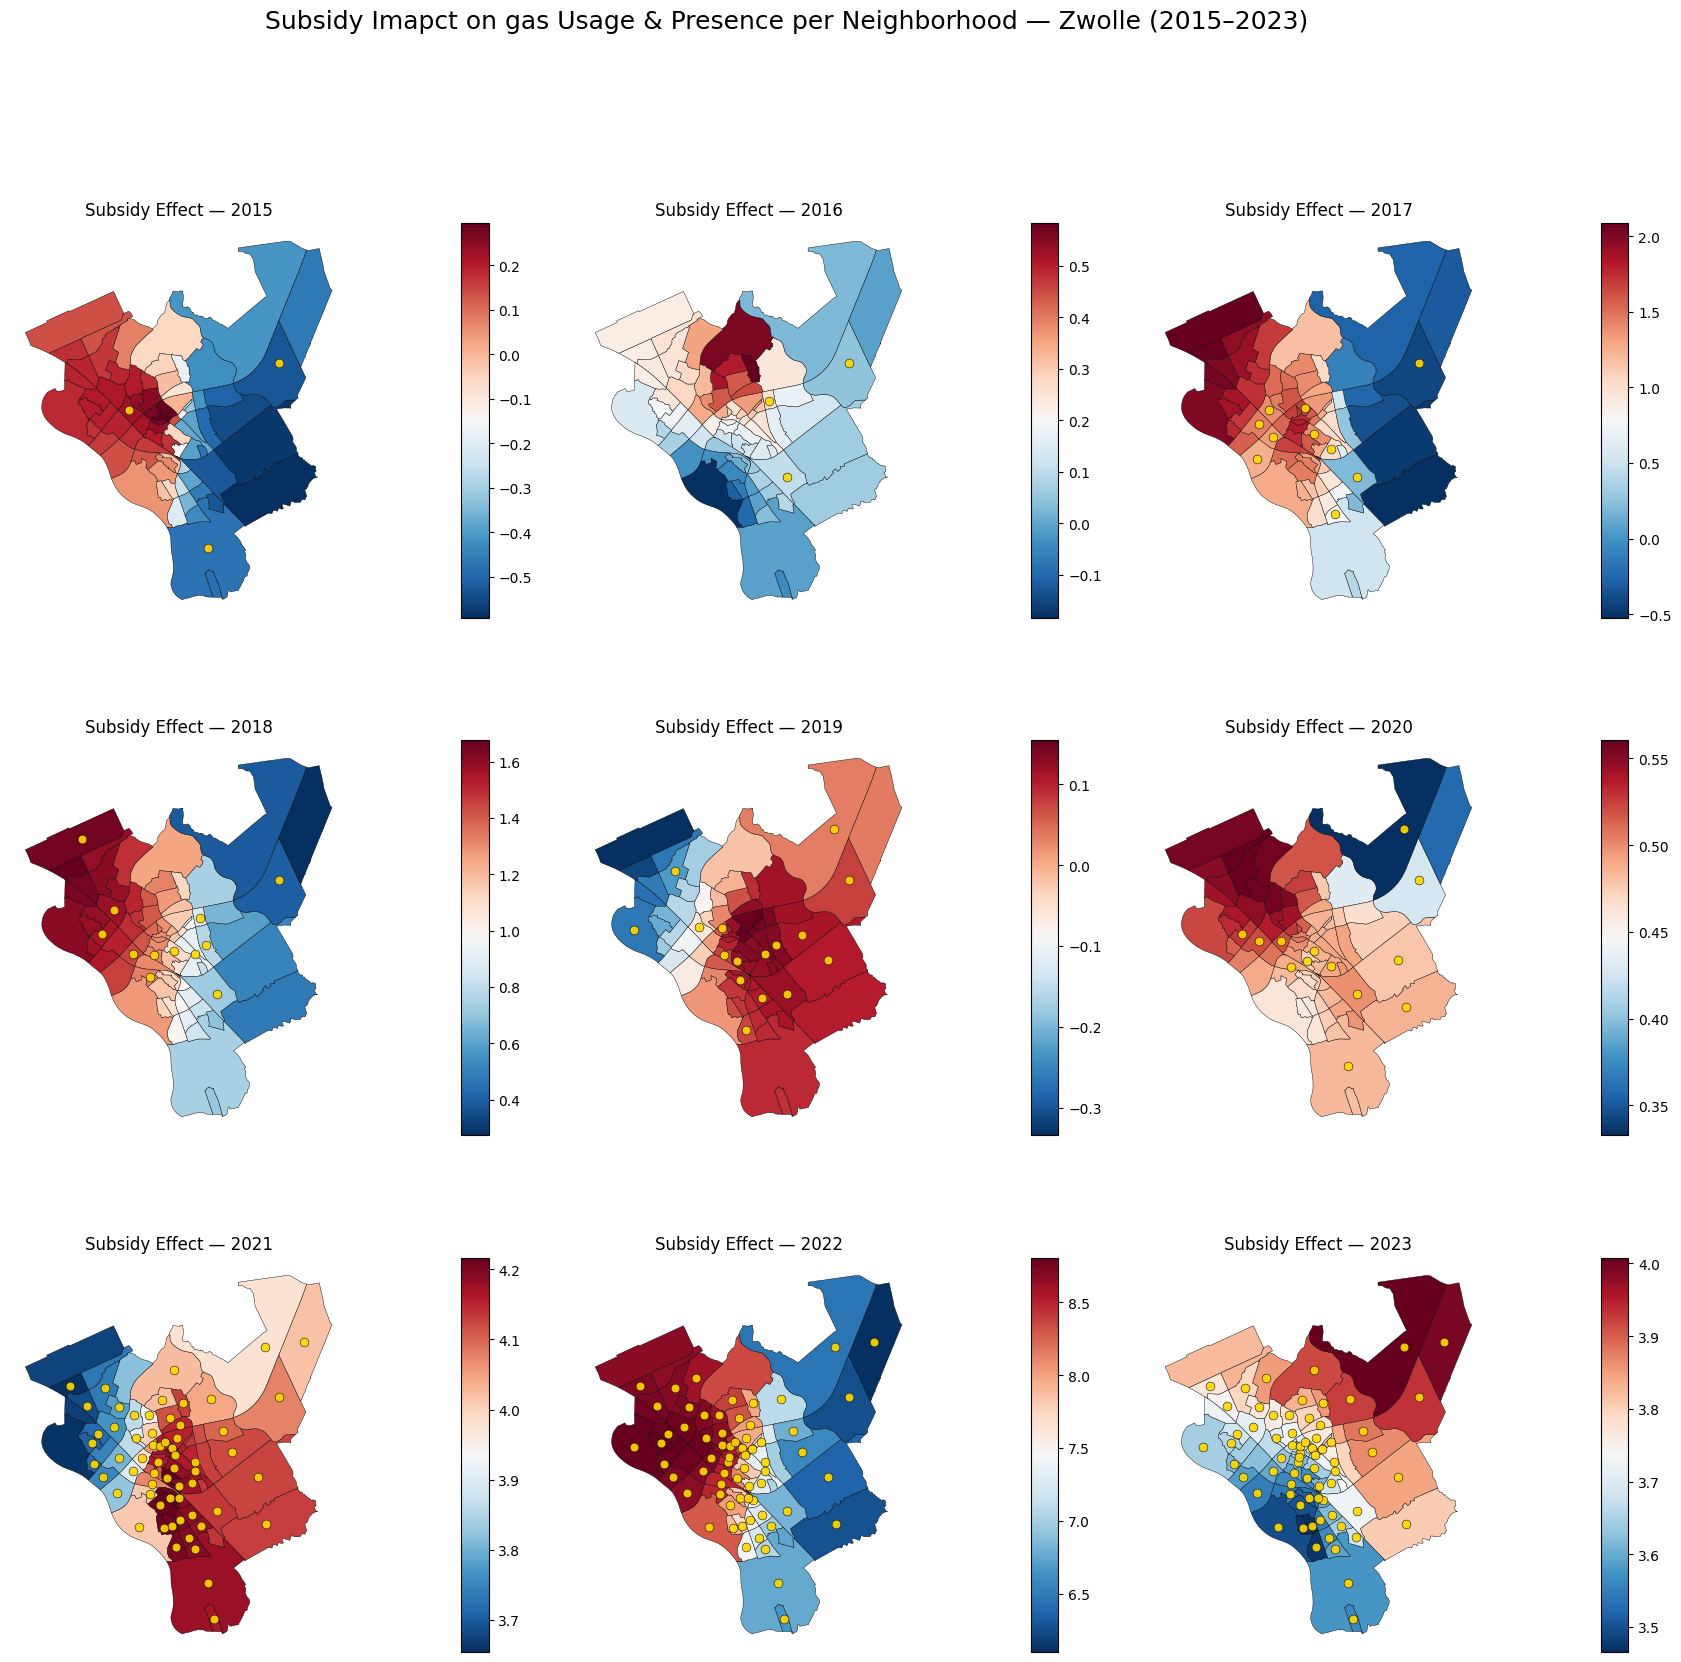

In [25]:

#  Store yearly maps
maps = {}

#  Loop through GWR years
for year, gwr_entry in gwr_data_by_year.items():
    if "total_subsidies" not in gwr_entry["X"].columns or gwr_entry.get("results") is None:
        continue

    X = gwr_entry["X"]
    y = gwr_entry["y"]
    coords = gwr_entry["coords"]
    results = gwr_entry["results"]

    #  Get coefficient index for 'total_subsidies'
    subsidy_index = X.columns.get_loc("total_subsidies") + 1
    local_coefs = results.params[:, subsidy_index]

    #  GWR output dataframe
    gwr_output = pd.DataFrame({
        "latitude": coords[:, 0],
        "longitude": coords[:, 1],
        "subsidy_effect": local_coefs,
        "subsidy_presence": (X["total_subsidies"].values > 0).astype(int),
        "gas_consumption": y.flatten()
    })

    gwr_gdf = gpd.GeoDataFrame(
        gwr_output,
        geometry=gpd.points_from_xy(gwr_output.longitude, gwr_output.latitude),
        crs="EPSG:4326"
    )

    #  Join with neighborhoods
    joined = gpd.sjoin(gwr_gdf, gdf_buurt, how="left", predicate="within")

    #  Aggregate to neighborhood
    summary = joined.groupby("buurt_naam").agg({
        "subsidy_effect": "mean",
        "subsidy_presence": "max"
    }).reset_index()

    #  Merge back with map
    gdf_map = gdf_buurt.merge(summary, on="buurt_naam", how="left")
    gdf_map["rep_point"] = gdf_map.geometry.representative_point()
    gdf_points = gdf_map.set_geometry("rep_point")

    #  Store data for plotting
    maps[year] = {
        "gdf_map": gdf_map,
        "gdf_points": gdf_points,
        "vmin": gdf_map["subsidy_effect"].min(),
        "vmax": gdf_map["subsidy_effect"].max()
    }

#  Plotting setup
n_cols = 3
n_rows = int(np.ceil(len(maps) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 6))
axes = axes.flatten()

#  Draw each map with its own colorbar
for i, (year, data) in enumerate(sorted(maps.items())):
    ax = axes[i]
    gdf_map = data["gdf_map"]
    gdf_points = data["gdf_points"]
    vmin, vmax = data["vmin"], data["vmax"]

    #  Create space for colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    #  Draw base map
    gdf_map.plot(
        column="subsidy_effect",
        cmap="RdBu_r",
        ax=ax,
        edgecolor="black",
        linewidth=0.3,
        legend=True,
        cax=cax,
        vmin=vmin,
        vmax=vmax,
        missing_kwds={"color": "lightgrey"}
    )

    #  Plot subsidy presence
    presence_layer = gdf_points[gdf_points["subsidy_presence"] == 1]
    presence_layer.plot(
        ax=ax,
        color="gold",
        markersize=40,
        edgecolor="black",
        linewidth=0.4,
        alpha=0.9
    )

    ax.set_title(f"Subsidy Effect — {year}", fontsize=12)
    ax.axis("off")

#  Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

#  Final layout
plt.suptitle("Subsidy Imapct on gas Usage & Presence per Neighborhood — Zwolle (2015–2023)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Checking if last years subsidies affect thsi years subsidies

## Data prepation for lagged effect

In [26]:


# Step 1: Compute lagged subsidy variable
merged = merged.sort_values(["buurt_naam", "year"])
merged["subsidies_lag1"] = merged.groupby("buurt_naam")["total_subsidies"].shift(1)

# Step 2: Store lagged GWR data
lagged_gwr_data_by_year = {}

for year in range(2016, 2024):  # Start from 2016 (2015 has no lag)
    if year not in retained_by_year:
        print(f" No retained variable list for {year}. Skipping.")
        continue

    data_year = merged[merged["year"] == year].copy().reset_index(drop=True)
    if data_year.empty:
        print(f" No data for year {year}. Skipping.")
        continue

    # Filter out rows with missing lagged subsidy
    data_year = data_year[~data_year["subsidies_lag1"].isna()].copy()
    if data_year.empty:
        print(f" All rows missing lagged subsidies for {year}. Skipping.")
        continue

    coords = data_year[["latitude", "longitude"]].values
    y = data_year[["gas_consumption_TJ"]].values

    # Replace total_subsidies with subsidies_lag1 in predictors
    predictors = [v if v != 'total_subsidies' else 'subsidies_lag1'
                  for v in retained_by_year[year]
                  if v not in ['gas_consumption_TJ', 'electricity_consumption_GWh']]

    # Identify policy and control variables
    policy_vars = [v for v in predictors if 'subsidy' in v.lower() or 'subsidies' in v.lower() or 'coaching' in v.lower()]
    control_vars = [v for v in predictors if v not in policy_vars]

    # Drop near-zero variance variables
    stds = data_year[predictors].std()
    nz_vars = stds[stds < 1e-5].index.tolist()
    control_vars = [v for v in control_vars if v not in nz_vars]
    policy_vars = [v for v in policy_vars if v not in nz_vars]

    final_predictors = control_vars + policy_vars
    X = data_year[final_predictors].copy()

    # Convert object-type columns to numeric
    for col in X.select_dtypes(include="object").columns:
        X[col] = pd.to_numeric(X[col], errors="coerce")

    # Fill NA in policy vars and drop rows with NA elsewhere
    if policy_vars:
        X[policy_vars] = X[policy_vars].fillna(0)
    X = X.dropna()
    y = y[X.index]
    coords = coords[X.index]

    if len(X) < 30:
        print(f" Not enough data for year {year}. Skipping.")
        continue

    # Standardize features
    X_scaled = StandardScaler().fit_transform(X)

    # Store in lagged GWR structure
    lagged_gwr_data_by_year[year] = {
        "X": X,
        "X_standardized": X_scaled,
        "y": y,
        "coords": coords,
        "included_policy_vars": policy_vars,
        "feature_names": list(X.columns)
    }

    print(f" Prepared lagged GWR data for {year} — Policy vars: {policy_vars}")

print(" Done preparing GWR data with lagged subsidies!")


 Prepared lagged GWR data for 2016 — Policy vars: ['subsidies_lag1']
 Prepared lagged GWR data for 2017 — Policy vars: ['subsidies_lag1']
 Prepared lagged GWR data for 2018 — Policy vars: ['subsidies_lag1']
 Prepared lagged GWR data for 2019 — Policy vars: ['subsidies_lag1']
 Prepared lagged GWR data for 2020 — Policy vars: ['subsidies_lag1']
 Prepared lagged GWR data for 2021 — Policy vars: ['subsidies_lag1']
 Prepared lagged GWR data for 2022 — Policy vars: ['subsidies_lag1']
 Prepared lagged GWR data for 2023 — Policy vars: ['coaching_sessions', 'subsidies_lag1']
 Done preparing GWR data with lagged subsidies!


## GWR

In [27]:


# Store GWR effect summaries per year (lagged effects)
lagged_all_effects = {}

# Loop over years in lagged GWR data
for year in sorted(lagged_gwr_data_by_year.keys()):
    print(f"\n Running GWR for year {year} (Lagged)...")

    X = lagged_gwr_data_by_year[year]["X"]
    X_scaled = lagged_gwr_data_by_year[year]["X_standardized"]
    y = lagged_gwr_data_by_year[year]["y"]
    coords = lagged_gwr_data_by_year[year]["coords"]
    policy_vars = lagged_gwr_data_by_year[year].get("included_policy_vars", [])

    try:
        #  Bandwidth selection and model fitting
        bw = Sel_BW(coords, y, X_scaled, kernel='bisquare', fixed=True).search()
        model = GWR(coords, y, X_scaled, bw, kernel='bisquare', fixed=True)
        results = model.fit()

        # Store results
        lagged_gwr_data_by_year[year]["results"] = results

        #  Identify feature order in results
        used_param_count = results.params.shape[1] - 1  # exclude intercept
        used_cols = list(X.columns[:used_param_count])

        #  Compute summary stats for policy variables
        effect_summaries = {}
        for var in policy_vars:
            if var in used_cols:
                idx = used_cols.index(var)
                local_coefs = results.params[:, idx + 1]  # +1 for intercept skip
                effect_summaries[var] = {
                    "mean": float(np.mean(local_coefs)),
                    "min": float(np.min(local_coefs)),
                    "max": float(np.max(local_coefs)),
                    "std": float(np.std(local_coefs))
                }
            else:
                effect_summaries[var] = " Dropped due to multicollinearity or low variance."

        # Step 5: Store summary
        lagged_all_effects[year] = effect_summaries

        # Step 6: Print summary
        print("\n Lagged Policy Effect Summary:")
        for var, stats in effect_summaries.items():
            print(f"  {var}: {stats}")

        print("\n GWR Summary:")
        print(results.summary())

    except Exception as e:
        print(f" GWR failed for year {year}: {e}")
        lagged_all_effects[year] = {"error": str(e)}



 Running GWR for year 2016 (Lagged)...

 Lagged Policy Effect Summary:
  subsidies_lag1: {'mean': -0.4238441875742826, 'min': -0.47227165744349037, 'max': -0.3831252953451638, 'std': 0.018197102679321304}

 GWR Summary:
Model type                                                         Gaussian
Number of observations:                                                  78
Number of covariates:                                                     9

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1691.541
Log-likelihood:                                                    -230.668
AIC:                                                                479.336
AICc:                                                               484.620
BIC:                                                               1390.928
R2:                                                                 

## Visualization of the lagged effect

In [28]:
choropleth_maps = {}
all_coefs = []

for year in sorted(lagged_gwr_data_by_year.keys()):
    results = lagged_gwr_data_by_year[year].get("results")
    X = lagged_gwr_data_by_year[year]["X"]
    coords = lagged_gwr_data_by_year[year]["coords"]

    if results is None or "subsidies_lag1" not in X.columns:
        print(f" Skipping {year} — no results or 'subsidies_lag1' not found.")
        continue

    coef_idx = list(X.columns).index("subsidies_lag1") + 1  # +1 to skip intercept
    local_coefs = results.params[:, coef_idx]

    df = pd.DataFrame({
        "longitude": coords[:, 1],
        "latitude": coords[:, 0],
        "subsidies_lag1_effect": local_coefs
    })

    gdf_points = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
        crs="EPSG:4326"
    )

    # Spatial join with neighborhoods
    joined = gpd.sjoin(gdf_points, gdf_buurt, how="left", predicate="within")

    # Average effect per neighborhood
    summary = joined.groupby("buurt_naam")["subsidies_lag1_effect"].mean().reset_index()

    # Merge into base map
    gdf_map = gdf_buurt.merge(summary, on="buurt_naam", how="left")
    choropleth_maps[year] = gdf_map

    # Store coefficients for scale harmonization later
    all_coefs.append(summary["subsidies_lag1_effect"])

print(" Choropleth maps for 'subsidies_lag1' prepared.")


 Choropleth maps for 'subsidies_lag1' prepared.


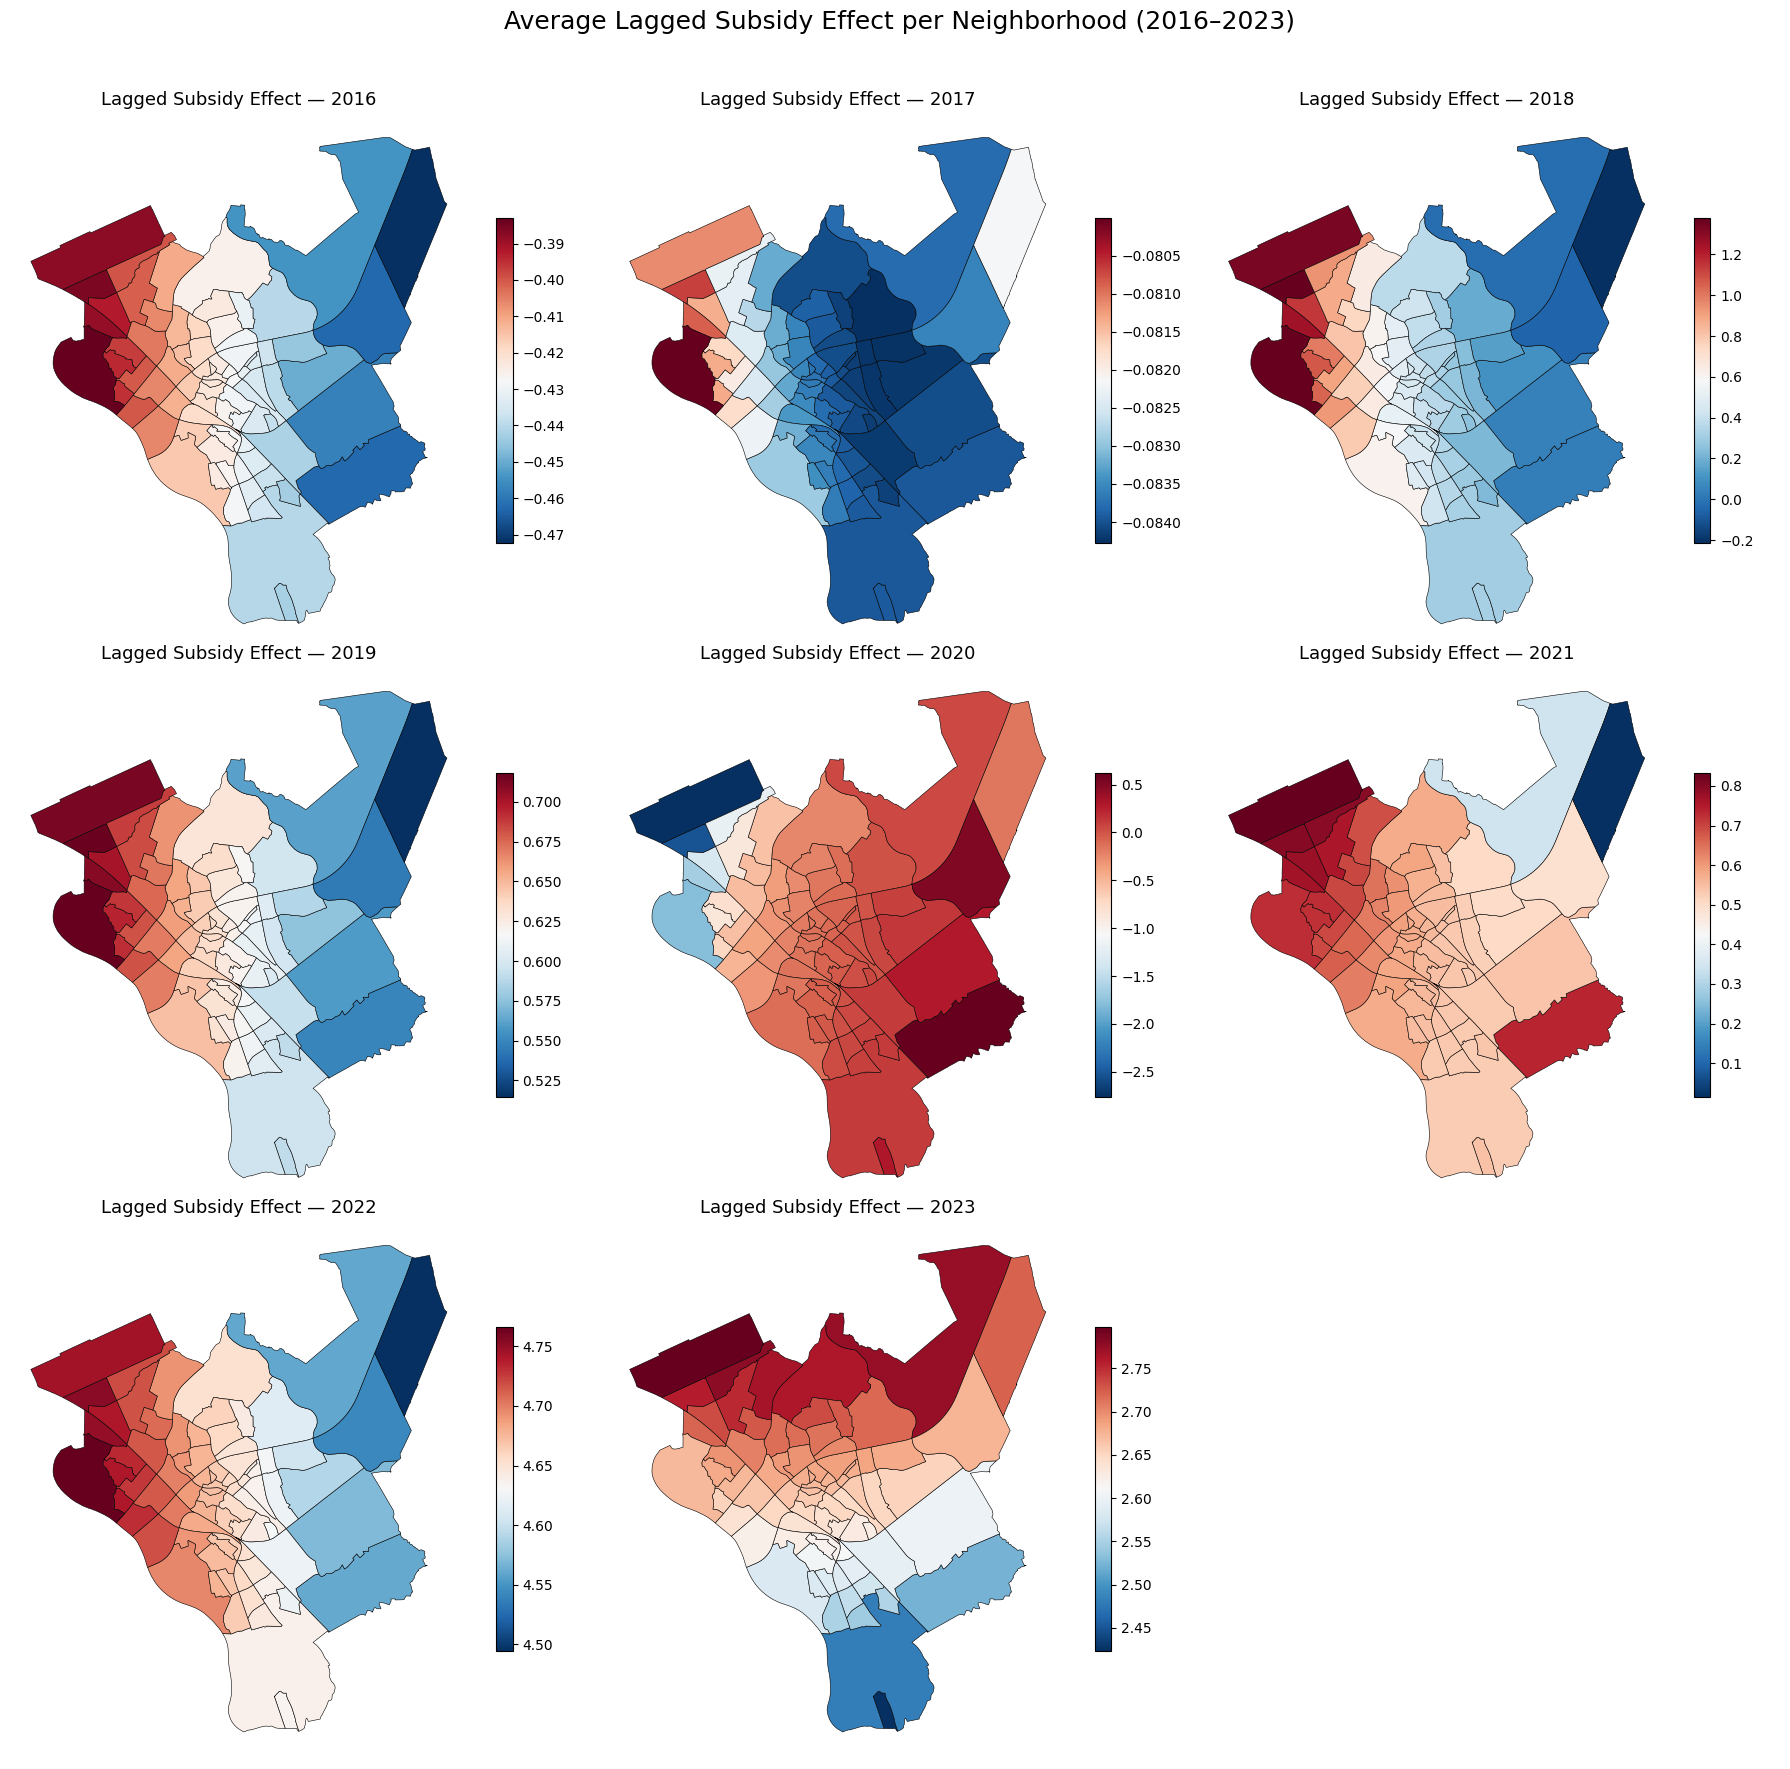

In [29]:

# Layout setup
n_cols = 3
n_rows = int(np.ceil(len(choropleth_maps) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 6))
axes = axes.flatten()

# Plot each map with local color scaling
for i, (year, gdf_map) in enumerate(sorted(choropleth_maps.items())):
    ax = axes[i]
    
    #  Use year-specific min/max for color contrast
    values = gdf_map["subsidies_lag1_effect"]
    year_vmin = values.min()
    year_vmax = values.max()

    gdf_map.plot(
        column="subsidies_lag1_effect",
        cmap="RdBu_r",
        ax=ax,
        edgecolor="black",
        linewidth=0.4,
        missing_kwds={"color": "lightgrey"},
        vmin=year_vmin,
        vmax=year_vmax,
        legend=True,
        legend_kwds={"shrink": 0.6}
    )

    ax.set_title(f"Lagged Subsidy Effect — {year}", fontsize=13)
    ax.axis("off")

# Turn off unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle(" Average Lagged Subsidy Effect per Neighborhood (2016–2023)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
